<a href="https://colab.research.google.com/github/Maxindrull2/APRENDIZAJE_AUTOMATICO_23_24/blob/main/LAB01_Grupo_A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 1**

Asignatura: Mineria de datos

Profesor: Carlos Emilio Rabazo Márquez

Grupo: A05

Integrantes: Natalia Iglesias, Sandra Millán, Ángel Pardo y Hugo Santos



# **Ejercicio 1**

A finales de 2020 empezó la vacunación del COVID-19 que ha producido la mayor pandemia mundial que se recuerda. Algunos países, en vista de los problemas que podrían causar futuras pandemias, quieren saber qué país está llevando el plan de vacunación más eficiente. Para ello vamos a obtener cual es la evolución del número de vacunados en el tiempo usando el set de datos vacunaciones.csv.
* Lo primero será analizar los missing values de la columna people vaccinated. Tras el análisis se decidirá que acción llevar acabo con dichos datos, ya sea la eliminación o reconstrucción. Para ello se tratará de realizar y evaluar el operador de recontrucción basado en la media de los 3 días anteriores.
* Una vez reconstruidos los datos se buscará determinar cuál es el país con mejor plan de vacunación dentro de los 5 países con más registros. Para ello, se empleará la constancia como métrica de éxito.

Se cargan librerías y la base de datos a emplear.

In [1]:
# Importar la biblioteca pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.font_manager import FontProperties

# Cargar un archivo CSV desde el sistema local
from google.colab import files
uploaded = files.upload()

Saving vacunaciones.csv to vacunaciones (1).csv


Se guarda la base de datos en la variable df.

In [2]:
df = pd.read_csv('/content/vacunaciones.csv')

Se visualizan los detalles de los datos de la base. Estos incluyen el número de entradas existentes, las columnas, las entradas no nulas de cada columna y el tipo de dato en ellas.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3208 entries, 0 to 3207
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              3208 non-null   object 
 1   iso_code                             2952 non-null   object 
 2   date                                 3208 non-null   object 
 3   total_vaccinations                   2084 non-null   float64
 4   people_vaccinated                    1727 non-null   float64
 5   people_fully_vaccinated              1094 non-null   float64
 6   daily_vaccinations_raw               1735 non-null   float64
 7   daily_vaccinations                   3083 non-null   float64
 8   total_vaccinations_per_hundred       2084 non-null   float64
 9   people_vaccinated_per_hundred        1727 non-null   float64
 10  people_fully_vaccinated_per_hundred  1094 non-null   float64
 11  daily_vaccinations_per_million

In [4]:
display(df.head())

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


No se tiene información sobre el significado específico de cada una de las variables, pero su tratamiento será el siguiente:

* country: Nombre del país
* iso_code: Código del país
* date: Fecha de los datos
* total_vaccinations: Vacunaciones totales de la población
* people_vaccinated: Personas totales vacunadas
* people_fully_vaccinated: Personas con la vacunación completa
* daily_vaccinations_raw: Vacunaciones diarias registradas sobre el total
* daily_vaccinations: Vacunaciones diarias esperadas
* total_vaccinations_per_hundred: Vacunaciones totales por 100 habitantes
* people_vaccinated_per_hundred: Personas vacunadas por 100 habitantes
* people_fully_vaccinated_per_hundred: Personas con vacunación completa por 100 habitantes
* daily_vaccinations_per_million: Vacunaciones diarias esperadas por millón
* vaccines: Tipo de vacuna
* source_name: Nombre de la página web de datos
* source_website: Enlace de la página web de datos

Gracias a estos datos se sabe que existen 3208 entradas disponibles y que las columnas de country, vaccines, source_name y source_website están completas, sin datos null.

A continuación se estudian los "**missing values**" de la columna “**people vaccinated**” para su análisis.

In [5]:
print("Número de nulls:", df['people_vaccinated'].isnull().sum())
print("Porcentaje de nulls:", int(df['people_vaccinated'].isnull().sum()/3208*100))

Número de nulls: 1481
Porcentaje de nulls: 46


Casi la mitad de los datos de la variable "people_vaccinated" son null, por lo que para realizar un análisis sobre esta, se va a intentar **reconstruir los datos** null mediante los datos ya existentes.

Para el estudio de la columna “people vaccinated”, las variables esenciales a tener en cuenta son “**people vaccinated**”, el país de los datos ("**country**") y la fecha en la que se tomaron los datos ("**date**"). A continuación se muestran estos datos de un país específico, Argentina.

In [6]:
display(df.loc[df['country'] == 'Argentina'][['country', 'date', 'people_vaccinated']].head(100))

,country,date,people_vaccinated
60,Argentina,2020-12-29,NaN
61,Argentina,2020-12-30,NaN
62,Argentina,2020-12-31,NaN
63,Argentina,2021-01-01,NaN
64,Argentina,2021-01-02,NaN
65,Argentina,2021-01-03,NaN
66,Argentina,2021-01-04,NaN
67,Argentina,2021-01-05,NaN
68,Argentina,2021-01-06,NaN
69,Argentina,2021-01-07,NaN


Los datos de "people_vaccinated" **dependen del país** en el que se hayan recogido. Por lo tanto, para su análisis, se debe tener en cuenta esta dependencia para extraer conclusiones válidas. Para ello, se recoge en una lista todos los países de la base de datos.

In [7]:
opciones_paises = df['country'].unique()

# Imprimir la lista de opciones
print(opciones_paises)

['Albania' 'Algeria' 'Andorra' 'Anguilla' 'Argentina' 'Austria'
 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belgium' 'Bermuda' 'Bolivia'
 'Brazil' 'Bulgaria' 'Cambodia' 'Canada' 'Cayman Islands' 'Chile' 'China'
 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Egypt'
 'England' 'Estonia' 'Faeroe Islands' 'Finland' 'France' 'Germany'
 'Gibraltar' 'Greece' 'Greenland' 'Guernsey' 'Hungary' 'Iceland' 'India'
 'Indonesia' 'Iran' 'Ireland' 'Isle of Man' 'Israel' 'Italy' 'Jersey'
 'Kuwait' 'Latvia' 'Liechtenstein' 'Lithuania' 'Luxembourg' 'Maldives'
 'Malta' 'Mauritius' 'Mexico' 'Monaco' 'Morocco' 'Myanmar' 'Nepal'
 'Netherlands' 'Northern Cyprus' 'Northern Ireland' 'Norway' 'Oman'
 'Pakistan' 'Panama' 'Peru' 'Poland' 'Portugal' 'Qatar' 'Romania' 'Russia'
 'Saint Helena' 'Saudi Arabia' 'Scotland' 'Serbia' 'Seychelles'
 'Singapore' 'Slovakia' 'Slovenia' 'Spain' 'Sri Lanka' 'Sweden'
 'Switzerland' 'Turkey' 'Turks and Caicos Islands' 'United Arab Emirates'
 'United Kingdom' 'United State

Se cuentan el número de registros que posee cada uno de los países.

In [8]:
# Obtener el conteo de registros para cada tipo de país en la columna 'country'
conteo_paises = df['country'].value_counts()

print(conteo_paises)

Wales               64
England             64
Scotland            64
Northern Ireland    64
United Kingdom      64
                    ..
Cambodia             2
Algeria              2
Iran                 2
Greenland            1
Saint Helena         1
Name: country, Length: 90, dtype: int64


Se ordena el número de registros en orden alfabético para que esté en el mismo orden que la variable opciones_paises por facilidad de programación.

In [9]:
# Ordenar el conteo de países alfabéticamente por el nombre del país
conteo_paises = conteo_paises.sort_index()

# Imprimir el conteo de registros para cada país ordenado alfabéticamente
print(conteo_paises)

Albania                     31
Algeria                      2
Andorra                     17
Anguilla                    10
Argentina                   49
                            ..
Turks and Caicos Islands    30
United Arab Emirates        42
United Kingdom              64
United States               57
Wales                       64
Name: country, Length: 90, dtype: int64


La primera técnica a emplear para reconstruir los datos emplea la descripción de la propia base de datos. La variable "total_vaccinations" representa las vacunaciones totales dentro de un país, "people_vaccinated" las personas vacunadas y "people_fully_vaccinated" las que han recibido la vacunación completa.

No se tienen datos específicos sobre cómo se calcula "total_vaccinations" ni cuántos tipos diferentes de vacunación comprende. Del mismo modo, no se sabe si "people_vaccinated" y "people_fully_vaccinated" son mutuamente excluyentes. Sin embargo, según la visualización de datos, se sugiere que **"total_vaccinations" ~ "people_vaccinated" + "people_fully_vaccinated"**.

Además, los datos de "people_fully_vaccinated" parecen ser menos representativos que los de "people_vaccinated". Por lo tanto, se intuye que en aquellos casos donde no exista registro (NaN) en "people_fully_vaccinated", entonces **"total_vaccinations" ~ "people_vaccinated"**.

Para confirmar si esta ecuación es cierta, se dibuja una gráfica donde el eje X es "total_vaccinations" y el eje Y es "people_vaccinated" + "people_fully_vaccinated". De esta manera, se dibuja una **recta de pendiente 1** que representa la igualdad (**X = Y**). **Si los datos siguen la recta, la ecuación es representativa**.

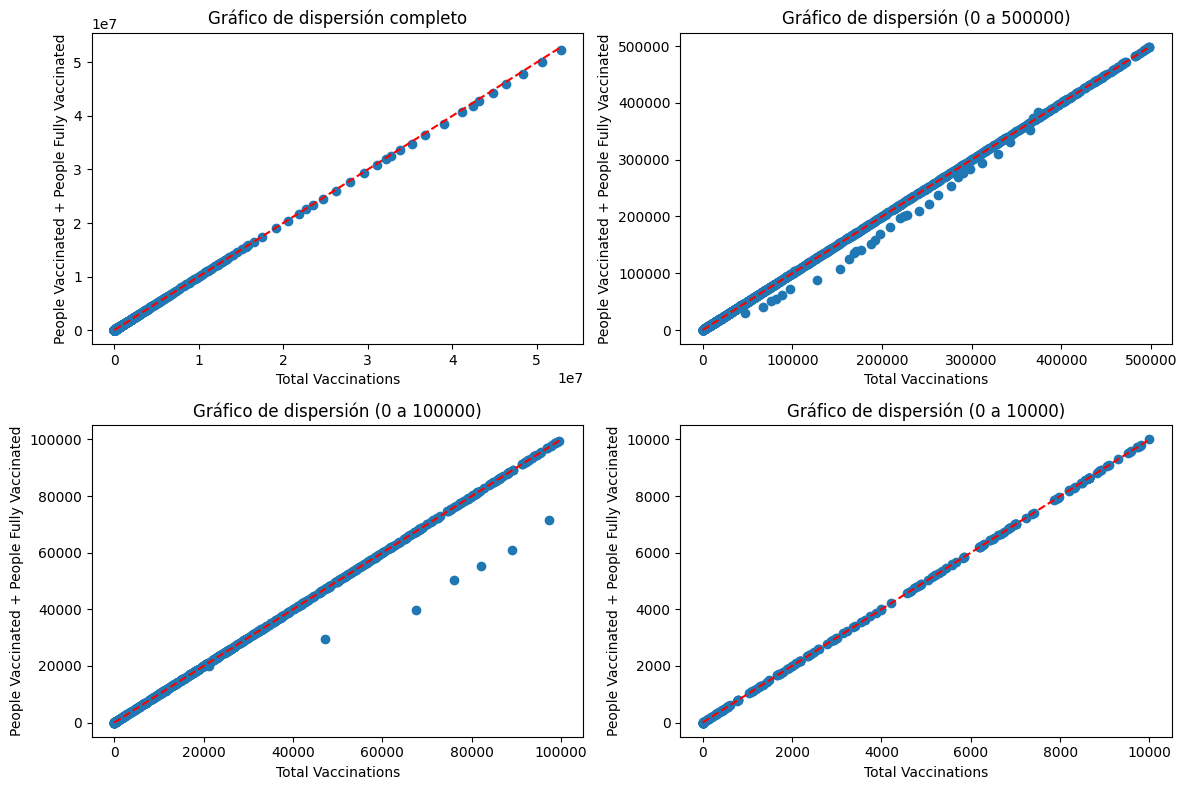

In [10]:
# Datos
x = df['total_vaccinations']
y = df['people_vaccinated'] + np.nan_to_num(df['people_fully_vaccinated'], nan=0)

# Creamos la figura y los subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Gráfico de dispersión completo
axs[0][0].scatter(x, y)
axs[0][0].set_xlabel('Total Vaccinations')
axs[0][0].set_ylabel('People Vaccinated + People Fully Vaccinated')
axs[0][0].set_title('Gráfico de dispersión completo')

# Línea discontinua y = x
axs[0][0].plot(np.unique(x), np.unique(x), color='red', linestyle='--')

# Gráfico de dispersión para datos de 0 a 500000
mask = x <= 500000
axs[0][1].scatter(x[mask], y[mask])
axs[0][1].set_xlabel('Total Vaccinations')
axs[0][1].set_ylabel('People Vaccinated + People Fully Vaccinated')
axs[0][1].set_title('Gráfico de dispersión (0 a 500000)')

# Línea discontinua y = x
axs[0][1].plot(np.unique(x[mask]), np.unique(x[mask]), color='red', linestyle='--')

# Gráfico de dispersión para datos de 0 a 100000
mask = x <= 100000
axs[1][0].scatter(x[mask], y[mask])
axs[1][0].set_xlabel('Total Vaccinations')
axs[1][0].set_ylabel('People Vaccinated + People Fully Vaccinated')
axs[1][0].set_title('Gráfico de dispersión (0 a 100000)')

# Línea discontinua y = x
axs[1][0].plot(np.unique(x[mask]), np.unique(x[mask]), color='red', linestyle='--')

# Gráfico de dispersión para datos de 0 a 10000
mask = x <= 10000
axs[1][1].scatter(x[mask], y[mask])
axs[1][1].set_xlabel('Total Vaccinations')
axs[1][1].set_ylabel('People Vaccinated + People Fully Vaccinated')
axs[1][1].set_title('Gráfico de dispersión (0 a 10000)')

# Línea discontinua y = x
axs[1][1].plot(np.unique(x[mask]), np.unique(x[mask]), color='red', linestyle='--')

# Mostramos los gráficos
plt.tight_layout()
plt.show()

Se puede confirmar que efectivamente **los datos siguen en su mayoría la recta X = Y**, especialmente en los valores más pequeños que corresponden a las primeras fechas de vacunación. Por lo tanto, la igualdad puede emplearse como una aproximación de "people_vaccinated", de manera que **"people_vaccinated" = "total_vaccinations" - "people_fully_vaccinated"**, siendo "people_fully_vaccinated" en el caso de que no exista ningún registro.

Se aplica esta fórmula para reconstruir algunos de los valores NaN. Se expone Argentina como ejemplo.

In [11]:
for p in opciones_paises:
  c = int(np.array(np.where(opciones_paises == p)))
  for i in range(conteo_paises[c]):
    if pd.isna(df.loc[df['country'] == p].iloc[i, 4]):
      j = i + sum(conteo_paises[0:c])
      df.loc[(df['country'] == p) & (df.index == j), 'people_vaccinated'] = df.loc[df['country'] == p].iloc[i, 3] - np.nan_to_num(df.loc[df['country'] == p].iloc[i, 5], nan=0)

display(df.loc[df['country'] == 'Argentina'][['country', 'date', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].head(100))

<ipython-input-11-638ac4c71f19>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = int(np.array(np.where(opciones_paises == p)))


,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated
60,Argentina,2020-12-29,700.0,700.0,NaN
61,Argentina,2020-12-30,NaN,NaN,NaN
62,Argentina,2020-12-31,32013.0,32013.0,NaN
63,Argentina,2021-01-01,NaN,NaN,NaN
64,Argentina,2021-01-02,NaN,NaN,NaN
65,Argentina,2021-01-03,NaN,NaN,NaN
66,Argentina,2021-01-04,39599.0,39599.0,NaN
67,Argentina,2021-01-05,NaN,NaN,NaN
68,Argentina,2021-01-06,NaN,NaN,NaN
69,Argentina,2021-01-07,NaN,NaN,NaN


Se revisan los valores nulos existentes.

In [12]:
print("Número de nulls:", df['people_vaccinated'].isnull().sum())
print("Porcentaje de nulls:", int(df['people_vaccinated'].isnull().sum()/3208*100))

Número de nulls: 1094
Porcentaje de nulls: 34


El número de valores nulos ha descendido, pero aún quedan bastantes, por lo que **se continúa buscando reconstruir los datos**.

La segunda técnica a emplear se basa en los datos tomados anteriormente. Se buscarán los datos obtenidos en los **3 días anteriores** dentro de un mismo país y se tomará la **media** de estos valores como el valor del día. En el caso de que no existan tres días anteriores, se tomarán 2, 1 o ninguno, según corresponda.

In [13]:
def mediatres(opciones_paises, conteo_paises, df):
  for p in opciones_paises:
    c = int(np.array(np.where(opciones_paises == p)))
    for i in range(conteo_paises[c]):
      if i>0:
        if pd.isna(df.loc[df['country'] == p].iloc[i-1, 4]) == 0: # quiero 0
          if pd.isna(df.loc[df['country'] == p].iloc[i, 4]): # quiero 1
            j = i + sum(conteo_paises[0:c])
            if i == 1:
              df.loc[(df['country'] == p) & (df.index == j), 'people_vaccinated'] = df.loc[df['country'] == p].iloc[i-1, 4]
            elif i == 2:
              df.loc[(df['country'] == p) & (df.index == j), 'people_vaccinated'] = np.nanmean(df.loc[df['country'] == p].iloc[i-2:i, 4])
            else:
              df.loc[(df['country'] == p) & (df.index == j), 'people_vaccinated'] = np.nanmean(df.loc[df['country'] == p].iloc[i-3:i, 4])

  return df

In [14]:
df = mediatres(opciones_paises, conteo_paises, df)
display(df.loc[df['country'] == 'Argentina'][['country', 'date', 'people_vaccinated']].head(100))

<ipython-input-13-937f38349b25>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = int(np.array(np.where(opciones_paises == p)))


,country,date,people_vaccinated
60,Argentina,2020-12-29,700.000000
61,Argentina,2020-12-30,700.000000
62,Argentina,2020-12-31,32013.000000
63,Argentina,2021-01-01,11137.666667
64,Argentina,2021-01-02,14616.888889
65,Argentina,2021-01-03,19255.851852
66,Argentina,2021-01-04,39599.000000
67,Argentina,2021-01-05,24490.580247
68,Argentina,2021-01-06,27781.810700
69,Argentina,2021-01-07,30623.796982



Tras aplicar la técnica, se comprueba cuántos valores nulos permanecen.

In [15]:
print(df['people_vaccinated'].isnull().sum())

0


Se muestra de manera gráfica los datos reconstruidos para confirmar su adecuación.

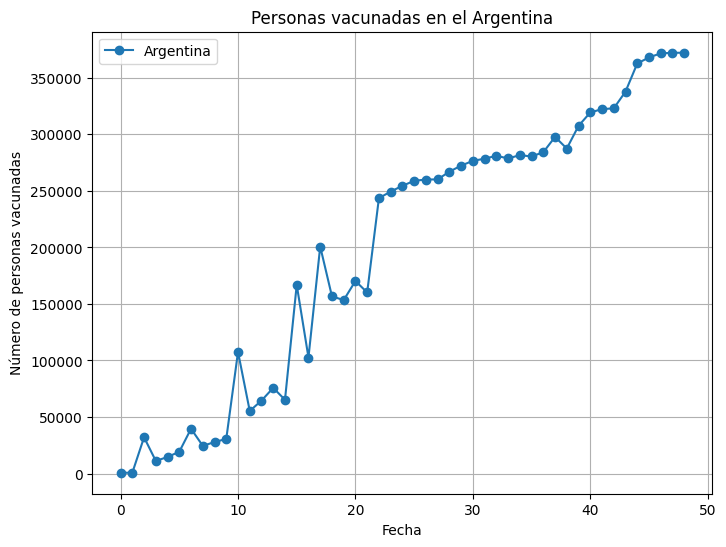

In [16]:
df_Argentina = df[df['country'] == 'Argentina']['people_vaccinated']

# Reindexar los DataFrames para ajustar sus índices al intervalo 0-3
df_Argentina.index = range(len(df_Argentina))

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(df_Argentina.index, df_Argentina, marker='o', linestyle='-', label='Argentina')
plt.title('Personas vacunadas en el Argentina')
plt.xlabel('Fecha')
plt.ylabel('Número de personas vacunadas')
plt.legend()
plt.grid(True)
plt.show()

Aquí se pueden extraer conclusiones sobre la técnica de reconstrucción. Se observa que la media de los tres días anteriores es **menor o igual** que la del **día anterior**, lo que arroja **resultados incongruentes** ya que no tendría sentido una disminución en el número de personas vacunadas. Esta aproximación poco adecuada podría pasar desapercibida, pero en ocasiones, como en el registro 10, se observa un descenso muy drástico y repentino, lo que la convierte en una **mala aproximación** de la variable.

Al ser una mala aproximación **no se va a trabajar con ella**, por lo que se **recuperan los datos** con las operaciones anteriores.

In [17]:
df = pd.read_csv('/content/vacunaciones.csv')
for p in opciones_paises:
  c = int(np.array(np.where(opciones_paises == p)))
  for i in range(conteo_paises[c]):
    if pd.isna(df.loc[df['country'] == p].iloc[i, 4]):
      j = i + sum(conteo_paises[0:c])
      df.loc[(df['country'] == p) & (df.index == j), 'people_vaccinated'] = df.loc[df['country'] == p].iloc[i, 3] - np.nan_to_num(df.loc[df['country'] == p].iloc[i, 5], nan=0)

<ipython-input-17-2ef7ae128ce3>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = int(np.array(np.where(opciones_paises == p)))


Visualizando los datos de forma general, se observa que la variable 'people_vaccinated' aumenta continuamente con el tiempo. Además, se nota que el **crecimiento** de la variable **no es lineal**, sino que está aumentando.

Para reconstruir los datos nulos, se procederá a **interpolar entre los valores existentes**. La diferencia entre los valores de los datos existentes determinará la **cantidad** a aumentar. La diferencia entre los índices será la **longitud**, que corresponderá con la cantidad de valores nulos entre ambos más uno. El objetivo es que cada dato nulo sea reconstruido de acuerdo con la cantidad en que los primeros datos agreguen menos que los últimos, simulando así el comportamiento de los datos proporcionados. Para esto, se utilizará la siguiente fórmula:

$$\Delta\ dato = \frac{indice}{\sum_{i=0}^{Nºindices} x}*cantidad$$

Aplicando esta fórmula, cada dato reconstruido **aumentará el valor anterior en un porcentaje de la cantidad**. Además, la **suma de todos los incrementos** resultará en la **cantidad total**, lo que representa una aproximación adecuada.

El **problema** al aplicar esta técnica radica en que los intervalos deben pertenecer al mismo país para evitar la **mezcla de datos**. Sin embargo, este problema **puede evitarse** si tanto el **primer como el último dato de cada país existen**, ya que en este caso todos los intervalos nulos serían internos y se podría aplicar la técnica directamente sobre la columna 'people_vaccinated'.

A continuación se muestra el número de países cuyos registros comienzan o terminan con valores nulos.

In [18]:
c_i = 0
c_f = 0

for i in range(len(conteo_paises)):
  if pd.isna(df.iloc[sum(conteo_paises[0:i]), 4]):
    c_i += 1

  if pd.isna(df.iloc[sum(conteo_paises[0:i+1])-1, 4]):
    c_f += 1

print('Número de paises con null al principio:',c_i)
print('Número de paises con null al final:',c_f)

Número de paises con null al principio: 0
Número de paises con null al final: 0


De esta manera se determina que la técnica no solamente puede ser aplicada sobre la columna sin tener en cuenta el pais en el que fue registrado el dato, sino que además **se reconstruirán todos los nulls** existentes en la columna.

Se aplica la técnica:

In [19]:
i = 0
cantidad = []
longitud = []

while i<sum(conteo_paises):
  if pd.isna(df.iloc[i, 4]):
    a = df.iloc[i-1, 4]
    c1 = i-1
    i = i+1

    while pd.isna(df.iloc[i, 4]):
      i = i+1

    b = df.iloc[i, 4]
    c2 = i
    cantidad = b-a
    longitud = c2-c1

    d = sum(range(longitud+1))
    for j in range(longitud):
      valor = (j+1)/d*cantidad
      df.loc[df.index == i-longitud+j+1, 'people_vaccinated'] = df.iloc[i-longitud+j, 4] + valor

  i = i+1

Se observa la evolución de Argentina para confirmar la adecuación de la técnica empelada

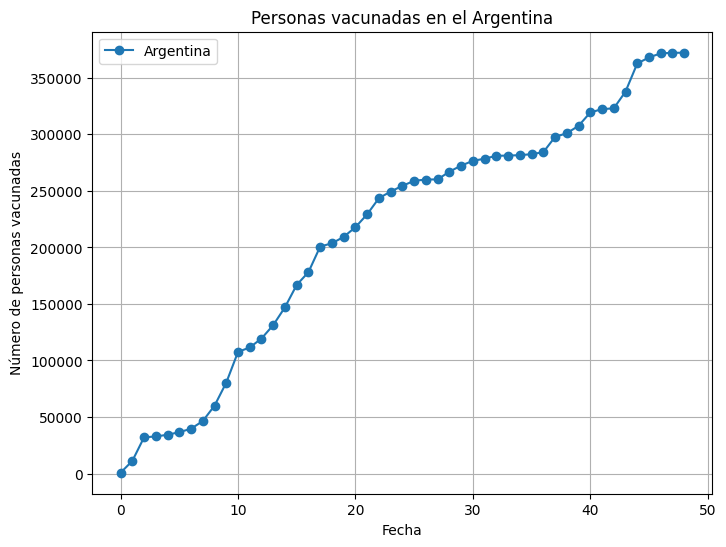

In [20]:
df_Argentina = df[df['country'] == 'Argentina']['people_vaccinated']

# Reindexar los DataFrames para ajustar sus índices al intervalo 0-3
df_Argentina.index = range(len(df_Argentina))

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(df_Argentina.index, df_Argentina, marker='o', linestyle='-', label='Argentina')
plt.title('Personas vacunadas en el Argentina')
plt.xlabel('Fecha')
plt.ylabel('Número de personas vacunadas')
plt.legend()
plt.grid(True)
plt.show()

Después de aplicar esta reconstrucción, se puede confirmar visualmente que es más acertada y que los datos reconstruidos tienen mucho más sentido en comparación con los datos originales. Por lo tanto, se determina que es una **reconstrucción adecuada**.


Tras aplicar la técnica, se comprueba cuántos valores nulos permanecen.

In [21]:
print(df['people_vaccinated'].isnull().sum())

0


No hay valores nulos restantes, por lo que la reconstrucción ha sido completada. A continuación, se procede a analizar los datos, centrándonos en los 5 países que tienen más registros (en días).

In [22]:
# Obtener el conteo de registros para cada tipo de país en la columna 'country'
conteo_paises = df['country'].value_counts()

print(conteo_paises[0:5])

Wales               64
England             64
Scotland            64
Northern Ireland    64
United Kingdom      64
Name: country, dtype: int64


Los cinco países cuentan con 64 días de registro. Nuestro análisis se centrará en la **evolución de las vacunaciones** en términos relativos, en lugar de enfocarse en los valores absolutos de vacunación. Para simplificar la representación gráfica, vamos a expresar los valores de todos los países en **porcentaje de vacunación**, puesto que no nos importa en si el número sino la evolución de este. Esto nos permitirá visualizar adecuadamente la evolución de cada país a lo largo del tiempo en una **misma escala**.

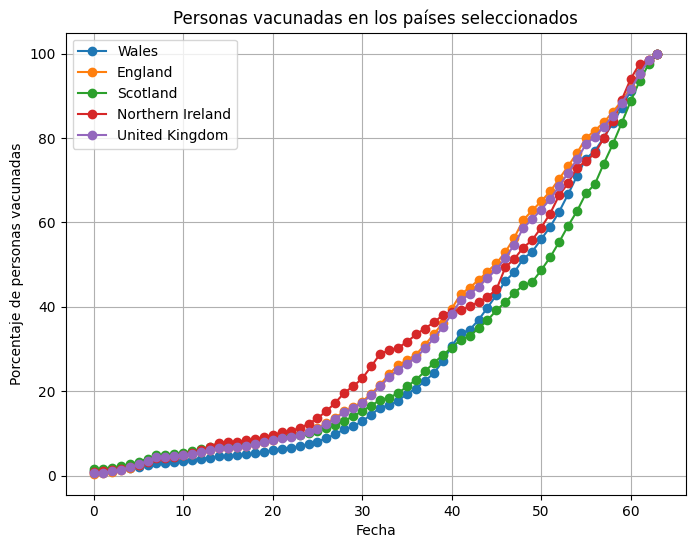

In [23]:
def plot_countries_vaccination(df, countries):
    plt.figure(figsize=(8, 6))
    for country in countries:
        df_country = df[df['country'] == country]['people_vaccinated'] / df[df['country'] == country]['people_vaccinated'].max() * 100
        df_country.index = range(len(df_country))
        plt.plot(df_country.index, df_country, marker='o', linestyle='-', label=country)

    plt.title('Personas vacunadas en los países seleccionados')
    plt.xlabel('Fecha')
    plt.ylabel('Porcentaje de personas vacunadas')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_countries_vaccination(df, ['Wales', 'England', 'Scotland', 'Northern Ireland','United Kingdom'])


En esta gráfica se puede visualizar cómo los cinco países tienen un **comportamiento parecido**. Esto podría atribuirse a las conexiones políticas entre ellos, dado que Wales, England, Scotland y Northern Ireland forman parte del United Kingdom. Aunque estos cuatro países formen parte del United Kingdom, es posible estudiar al United Kingdom de manera independiente, ya que los cuatro países que lo componen pueden tener desequilibrios entre sí, pero en su conjunto pueden contrarrestarse mutuamente y hacer que el United Kingdom sea estable.

Se puede apreciar una correspondencia **lógica de los datos**. A partir de aquí, el objetivo es seleccionar qué país es el más constante en la realización de las vacunaciones. Esto significa que sigue una razón constante de crecimiento acorde a una función, por lo que debe poder **aproximarse adecuadamente por un polinomio**.

Para obtener de manera analítica cuál es el país más constante, se calculará un **polinomio de regresión para cada uno de los países**. Este polinomio de regresión particular representa la constancia polinómica que siguen sus datos. Luego, se calculará el **Mean Square Error (MSE)** de los datos con respecto a la regresión para así determinar qué país es más **fiel a su regresión** y, por tanto, más constante.

El propósito principal de los polinomios de regresión es modelar datos de **manera suave**, evitando la interpolación entre puntos. Esto se debe a que polinomios de **grado bajo** (como 2 o 3) ofrecen una representación estable de la evolución de los datos a lo largo del tiempo, mientras que grados más altos pueden introducir curvas no realistas en las predicciones, acercandose demasiado a una interpolación. Es por este motivo que se emplea un polinomio de **grado 3** para ajustar los datos de cada país

In [24]:
def plotregresion(df_paises, Nombres, colores):
    num_plots = len(df_paises)
    num_rows = 2
    num_cols = 3  # Tres subplots en la primera fila, dos subplots en la segunda fila

    fig = plt.figure(figsize=(15, 7))
    gs = fig.add_gridspec(num_rows, num_cols)

    mse_values = []

    for i, (df_pais, Nombre, color) in enumerate(zip(df_paises, Nombres, colores)):
        X = df_pais.index.values.reshape(-1, 1)
        y = df_pais.values.reshape(-1, 1)

        # Crear un modelo de regresión cuadrática
        poly = PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)

        model = LinearRegression()

        # Entrenar el modelo
        model.fit(X_poly, y)

        # Predecir los valores de y usando el modelo entrenado
        y_pred = model.predict(X_poly)

        # Calcular errores
        mse = mean_squared_error(y, y_pred)
        mse_values.append(mse)

        # Calcular el número de fila y columna actual
        row = i // num_cols
        col = i % num_cols

        # Añadir subplots a la figura con el diseño personalizado
        if row == 1 and col == 1:
            ax = fig.add_subplot(gs[row, col+1])
        else:
            ax = fig.add_subplot(gs[row, col])

        # Graficar los datos originales y la curva de regresión
        ax.plot(X, y, marker='o', linestyle='-', label=Nombre, color=color, markersize=4)
        ax.plot(X, y_pred, color='black', linestyle='--', label='Curva de regresión')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Porcentaje vacunaciones')
        ax.set_title('Regresión de datos de vacunación en ' + Nombre)
        # Añadir el valor de MSE debajo a la derecha del título
        ax.text(0.95, 0.05, f'mse: {mse:.3f}', ha='right', va='bottom', transform=ax.transAxes, fontsize=12, color='black')
        ax.legend()

    # Ajustar diseño y mostrar la gráfica
    plt.tight_layout()
    plt.show()

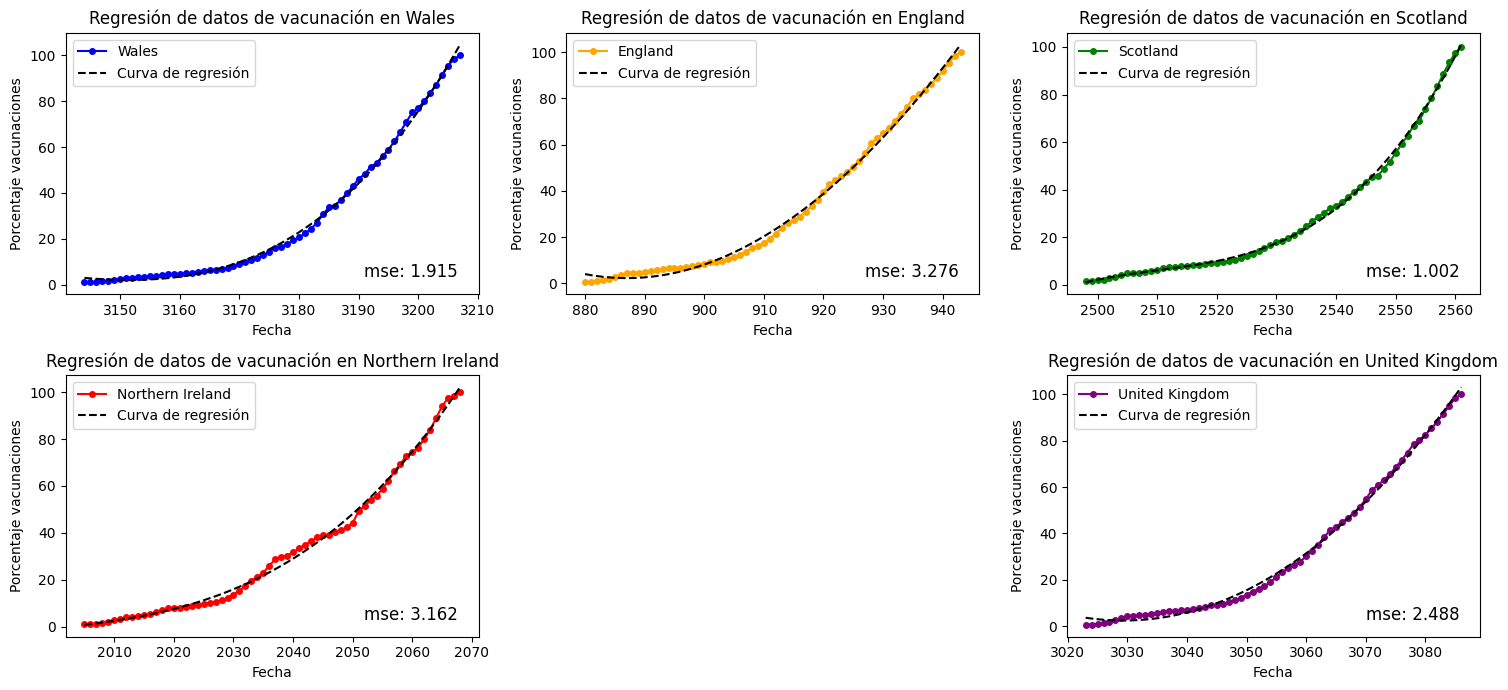

In [25]:
df_wales = df[df['country'] == 'Wales']['people_vaccinated']/df[df['country'] == 'Wales']['people_vaccinated'].max()*100
df_england = df[df['country'] == 'England']['people_vaccinated']/df[df['country'] == 'England']['people_vaccinated'].max()*100
df_Scotland = df[df['country'] == 'Scotland']['people_vaccinated']/df[df['country'] == 'Scotland']['people_vaccinated'].max()*100
df_Northern_Ireland = df[df['country'] == 'Northern Ireland']['people_vaccinated']/df[df['country'] == 'Northern Ireland']['people_vaccinated'].max()*100
df_United_Kingdom = df[df['country'] == 'United Kingdom']['people_vaccinated']/df[df['country'] == 'United Kingdom']['people_vaccinated'].max()*100

plotregresion([df_wales,df_england,df_Scotland,df_Northern_Ireland,df_United_Kingdom],
              ['Wales','England','Scotland','Northern Ireland','United Kingdom'],
              ['blue','orange','green','red','purple'])

Se observa que los polinomios de grado 3 se **ajustan bastante bien** a todos los datos, aunque ninguno muestra una constancia pura. Entre los países analizados, England y Northern Ireland exhiben menor constancia en la vacunación, evidenciándose visualmente cómo la evolución de sus datos pasa tanto por encima como por debajo de sus polinomios de regresión. Por otro lado, United Kingdom y Wales muestran una mayor fidelidad a su regresión, aunque aún presentan periodos de fallos que aunque mas ligeros evitan el ajuste excelente. En contraste, **Scotland** destaca como el país con la tasa de vacunación **más estable** de los cinco, con un ajuste bastante preciso, aunque con pequeñas desviaciones en torno al periodo 50. Este análisis se confirma analíticamente, ya que Scotland exhibe el menor valor del error cuadrático medio (**MSE**) con un valor de **1.002**.

Una vez encontrado el mejor plan de vacunación, correspondiente a Scotland, se va a proceder a interpretarlo. Para ello se muestra su evolución

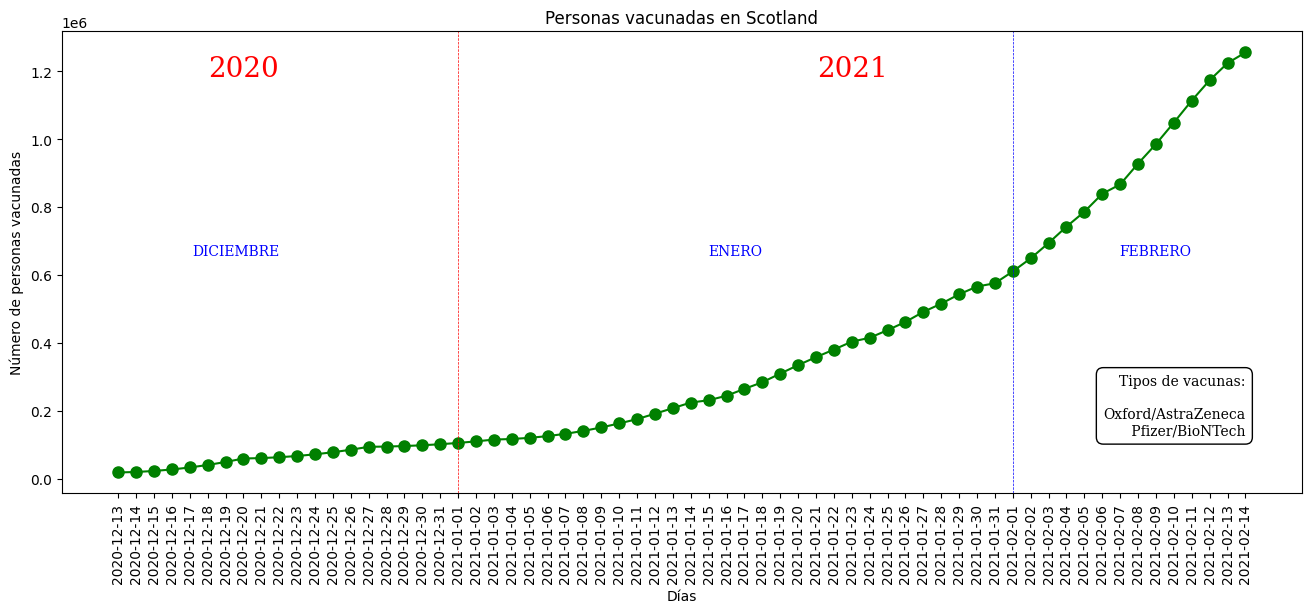

In [26]:
vacuna = df[df['country'] == 'Scotland']['vaccines'].unique()[0].split(',')

plt.figure(figsize=(16, 6))
plt.plot(df[df['country'] == 'Scotland']['date'],df[df['country'] == 'Scotland']['people_vaccinated'], color='green', marker='o', linestyle='-', markersize=8)
plt.axvline(x='2021-01-01', color='red', linestyle='--', linewidth=0.5)
plt.axvline(x='2021-02-01', color='blue', linestyle='--', linewidth=0.5)
plt.text('2020-12-22', plt.ylim()[1]*0.9, '2020', ha='right', color='red', fontsize=20, fontname='serif')
plt.text('2021-01-25', plt.ylim()[1]*0.9, '2021', ha='right', color='red', fontsize=20, fontname='serif')
plt.text('2020-12-22', plt.ylim()[1]*0.5, 'DICIEMBRE', ha='right', color='blue', fontsize=10, fontname='serif')
plt.text('2021-01-18', plt.ylim()[1]*0.5, 'ENERO', ha='right', color='blue', fontsize=10, fontname='serif')
plt.text('2021-02-11', plt.ylim()[1]*0.5, 'FEBRERO', ha='right', color='blue', fontsize=10, fontname='serif')
plt.text('2021-02-14', plt.ylim()[1]*0.1, 'Tipos de vacunas:\n\n'+vacuna[0]+'\n'+vacuna[1], ha='right', color='black', fontsize=10, fontname='serif', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
plt.title('Personas vacunadas en Scotland')
plt.xlabel('Días')
plt.ylabel('Número de personas vacunadas')
plt.xticks(rotation=90)
plt.show()

Analizando el plan de vacunación a lo largo de las fechas dadas se tiene que durante el primer mes del plan, desde el 13 de Diciembre de 2020 hasta el 13 de Enero de 2021, la tasa de vacunación es bastante baja, llegando únicamente a alcanzar a 200 mil personas vacunadas. El mes de **Diciembre** y **principios de Enero** tuvieron **malos registros** de vacunación, pero es a partir de la **segunda quincena de Enero** donde empieza a notarse la evolución y **mejora** del plan. Pasando 600 mil personas vacunadas en una quincena, triplicando el registro del mes anterior. La mejora no se limita únicamente a esta quincena, sino que además los **primeros días de Febrero mejoran** estas cifras llegando a **1.2 millones** de vacunaciones, doblando el número anterior de vacunados. Durante todo el plan de vacunación se emplearon tanto Oxford/astraZeneca y Pfizer/BioNTech como tipo de vacunación para los pacientes.

De esta manera se considera que el plan de vacunación realizado en Escocia comenzó de manera ligera pero con una **mejora robusta y constante** a lo largo del tiempo. Lo cual lo tradujo en el plan de vacunación mas constante del Reino Unido.

# **Ejercicio 2**

En este ejercicio se realizará un análisis exhaustivo de un conjunto de datos ambientales, específicamente mediciones realizadas por un sensor situado en el campus de la Universidad Francisco de Vitoria durante el año 2020. El dataset, denominado "ozone", incluye diversas variables relacionadas con la calidad del aire y condiciones meteorológicas. El objetivo es profundizar en el entendimiento de estos datos a través de cuatro tareas específicas:

+ **Análisis Unidimensional de Outliers:** Se investigará la presencia de valores atípicos (outliers) en tres variables clave: velocidad del viento (Wind_speed), lecturas de ozono (Ozone_reading) y visibilidad (Visibility). Esta tarea implica utilizar un tipo de gráfico adecuado para identificar dichos outliers, realizar una interpretación de los resultados obtenidos para cada variable y poder identificar posibles errores de medición.

+ **Estudio de Intersección y Unión de Outliers:** Se analizará cómo se relacionan los outliers entre dos variables específicas: velocidad del viento y visibilidad. Este análisis permitirá identificar si los valores atípicos en una variable tienden a coincidir con valores atípicos en la otra, lo cual podría sugerir patrones o fenómenos ambientales específicos que afectan simultáneamente a ambas mediciones.

+ **Categorización y Relación entre Variables:** Se categorizará algunas de las variables del dataset para descubrir posibles correlaciones o tendencias entre diferentes variables, lo que podría insinuar algún patrón sobre los factores que influyen en la calidad del aire y las condiciones meteorológicas.

+ **Distribución y Frecuencia de Variables por Días de Medición:** Finalmente, se examinará cómo se distribuyen las principales variables respecto a los días de medición. Se seleccionará y justificará el uso de un tipo de representación gráfica para visualizar esta distribución y las frecuencias de las variables, lo que permitirá entender cómo varían las condiciones ambientales y la calidad del aire a lo largo del año.

## **Librerías**

In [27]:
# Cargar base de datos
from google.colab import files

# Generales
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

## **Cargamos la base de datos**

Para cargar correctamente el dataset y asignar los nombres adecuados a las columnas, se **omite** la primera fila en el momento de cargar la base de datos, ya que los encabezados no están cuadrados de manera correcta. Posteriormente, se **agrega** una nueva fila al inicio del dataset que especifica los nombres de cada columna.



In [28]:
uploaded = files.upload()

Saving ozone.csv to ozone.csv


In [29]:
# Nombres de las columnas especificados
column_names = ["Month", "Day_of_month", "Day_of_week", "ozone_reading", "pressure_height", "Wind_speed", "Humidity", "Temperature_Sandburg", "Temperature_ElMonte", "Inversion_base_height", "Pressure_gradient", "Inversion_temperature", "Visibility"]

# Cargar el archivo CSV en un DataFrame de pandas sin la primera fila
df = pd.read_csv('/content/ozone.csv', header=None, skiprows=1)

# Asignar los nuevos nombres de columna al DataFrame
df.columns = column_names

# Mostrar las primeras filas del DataFrame modificado
df.head()

,Month,Day_of_month,Day_of_week,ozone_reading,pressure_height,Wind_speed,Humidity,Temperature_Sandburg,Temperature_ElMonte,Inversion_base_height,Pressure_gradient,Inversion_temperature,Visibility
0,1,5,1,5.34,5760,3,51,54,45.32,1450,25,57.02,60
1,1,6,2,5.77,5720,4,69,35,49.64,1568,15,53.78,60
2,1,7,3,3.69,5790,6,19,45,46.40,2631,-33,54.14,100
3,1,8,4,3.89,5790,3,25,55,52.70,554,-28,64.76,250
4,1,9,5,5.76,5700,3,73,41,48.02,2083,23,52.52,120


Se va a confirmar si existen registros nulos en las variables, asi como el tipo de cada una de ellas.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Month                  203 non-null    int64  
 1   Day_of_month           203 non-null    int64  
 2   Day_of_week            203 non-null    int64  
 3   ozone_reading          203 non-null    float64
 4   pressure_height        203 non-null    int64  
 5   Wind_speed             203 non-null    int64  
 6   Humidity               203 non-null    int64  
 7   Temperature_Sandburg   203 non-null    int64  
 8   Temperature_ElMonte    203 non-null    float64
 9   Inversion_base_height  203 non-null    int64  
 10  Pressure_gradient      203 non-null    int64  
 11  Inversion_temperature  203 non-null    float64
 12  Visibility             203 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 20.7 KB


Existen 203 registros en total y no hay ninguna variable con un valor nulo, por lo que no será necesaria ninguna operación de reconstrucción. Además, todos los tipos son numéricos, ya sea float o int.

**Descripción variables:**


1. **Month**: Mes del año en que se tomaron las mediciones
2. **Day_of_month**: Día del mes.
3. **Day_of_week**: Día de la semana.
4. **ozone_reading**: La concentración de ozono en la atmósfera, que es un indicador clave de la calidad del aire.
5. **pressure_height**: La altura de la presión atmosférica, que puede influir en la dispersión de los contaminantes.
6. **Wind_speed**: Velocidad del viento, que afecta la dispersión de los contaminantes en el aire.
7. **Humidity**: La humedad relativa, que puede afectar la capacidad del aire para contener contaminantes.
8. **Temperature_Sandburg**: Temperatura registrada en Sandburg.
9. **Temperature_ElMonte**: Temperatura registrada en El Monte.
10. **Inversion_base_height**: La altura a la que comienza la capa de inversión térmica, un fenómeno que puede atrapar contaminantes cerca de la superficie.
11. **Pressure_gradient**: El gradiente de presión, que puede influir en los patrones de viento y, por tanto, en la dispersión de los contaminantes.
12. **Inversion_temperature**: La temperatura en la base de la capa de inversión, importante para entender la estabilidad de la capa de inversión.
13. **Visibility**: Visibilidad, que puede ser afectada por la concentración de contaminantes en el aire.

Se va a mostrar una visualización de todas las variables para poder ver su distribución.

In [31]:
import matplotlib.pyplot as plt

def allHistogramas ():

  # Define una paleta de colores pastel
  pastel_palette = ['#A6B7AC', '#ECD5E3', '#C7CEEA', '#FFDDC1', '#A2D2FF', '#FFB3B3', '#C6EBBE',
                    '#FFD1A8', '#D6A2E8', '#A6E3E9', '#B9FFC8', '#FFADAD', '#BAED91']

  total_columns = len(column_names)

  # Calcula el número total de filas necesarias
  num_rows = (total_columns + 6) // 7  # Cambiado a 7 subplots por fila

  # Crea los subplots con la cantidad necesaria
  fig, axs = plt.subplots(num_rows, 7, figsize=(30, 3*num_rows))  # Ajustado el tamaño de la figura

  # Itera sobre las columnas y crea un histograma para cada una
  for i, column in enumerate(column_names):
      row = i // 7  # Ajustado para 7 subplots por fila
      col = i % 7
      # Selecciona un color pastel diferente para cada subplot
      color = pastel_palette[i % len(pastel_palette)]
      axs[row, col].hist(df[column], bins=20, color=color, edgecolor='black')
      axs[row, col].set_title(f'Histogram of {column}')
      axs[row, col].set_xlabel(column)
      axs[row, col].set_ylabel('Frequency')
      axs[row, col].grid(True)

  # Elimina los subplots vacíos si es necesario
  if total_columns < num_rows * 7:
      for i in range(total_columns, num_rows * 7):
          fig.delaxes(axs.flatten()[i])

  # Ajusta el diseño y muestra el gráfico
  plt.tight_layout()
  plt.show()

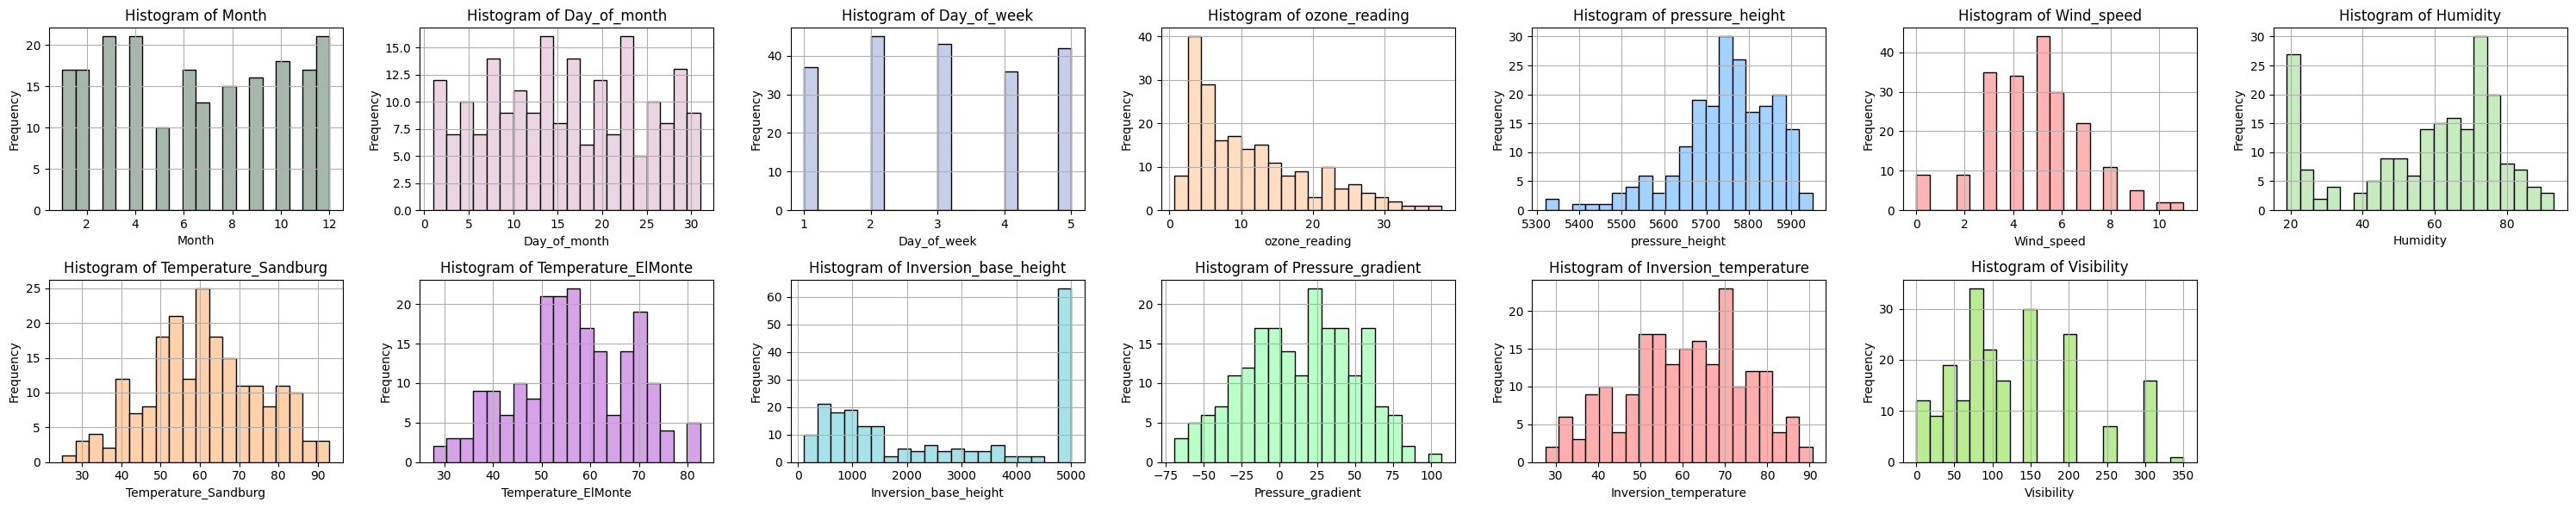

In [32]:
allHistogramas ()

### **Transformación fecha**

A continuación, se combinan las columnas del mes y del día para formar un único campo de fecha, junto con el año especificado 2020. Al hacer esto, se crea una representación completa de la fecha en el formato estándar de año-mes-día. Esta nueva columna de fecha se necesitará para los análisis y representacaiones posteriores.

In [33]:
# Crear una nueva columna de fecha combinando mes y día
df['fecha'] = pd.to_datetime('2020/' + df['Month'].astype(str) + '/' + df['Day_of_month'].astype(str), format='%Y/%m/%d')


# **Análisis de outliers**

En este apartado se va a realizar un anális de los valores atípicos o outliers de tres variables específicas (la velocidad del viento (`Wind_speed`), la lectura de ozono (`Ozone_reading`) y la visibilidad (`Visibility`). Esto ayudará a comprender mejor sus distribuciones y posibles anomalías.



### **Información acerca de las variables**

Para poder estudiar con mayor precisión nuestros outliers, es fundamental analizar cómo se **distribuyen a lo largo del tiempo**, considerando las posibles variaciones estacionales. Comprender que las condiciones climatológicas en enero difieren significativamente de las de junio nos lleva a la necesidad de una evaluación detallada.

Para este propósito, utilizaremos **histogramas** para visualizar la **distribución y frecuencia de los outliers** y la distirbución en función al tiempo, lo que a su vez nos permitirá tomar decisiones más informadas y precisas en el futuro.

In [34]:
# Colores para cada gráfico
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Variables del primer apartado
variables = ['Wind_speed', 'ozone_reading', 'Visibility']

**HISTOGRAMA**

Para estudiar la distribución que siguen las variable, se emplearán histogramas, un tipo de gráfica que permite observar la frecuencia de una variable cuantitativa mediante intervalos. Además, graficar histogramas para varias variables permite comparar directamente sus distribuciones para entender cómo una variable puede comportarse de manera similar o diferente a otra.

1. **Wind_speed**:
   - La distribución de `Wind_speed` parece aproximarse a una distribución normal, ya que tiene una forma de campana y es bastante simétrica alrededor de la media.
   - Esta distribución sugiere que las condiciones de viento en el campus no presentan extremos muy variados y tienden a ser moderadas la mayor parte del tiempo.

2. **ozone_reading**:
   - La distribución de `ozone_reading` se asemeja a una distribución exponencial (log normal). Tiene una concentración más alta de valores bajos con una cola larga hacia la derecha, lo que indica una distribución con sesgo hacia la derecha.
   - Hay una frecuencia significativa de valores bajos, y la frecuencia disminuye a medida que el nivel de ozono aumenta.
   - Este sesgo sugiere que las condiciones de alta concentración de ozono son menos frecuentes, pero aún ocurren con una variedad notable de valores más altos que el promedio.

3. **Visibility**:
   - En la distribución de `Visibility` se observan picos significativos en ciertos rangos de visibilidad, lo que podría indicar agrupaciones de condiciones de visibilidad típicas.

In [35]:
def histograma(var,dfMini,color,ax):
  ax.hist(dfMini, bins=30, alpha=0.5, color=color, edgecolor='black')
  ax.set_title(f'Histograma de {var}')
  ax.set_xlabel('Valor')
  ax.set_ylabel('Frecuencia')

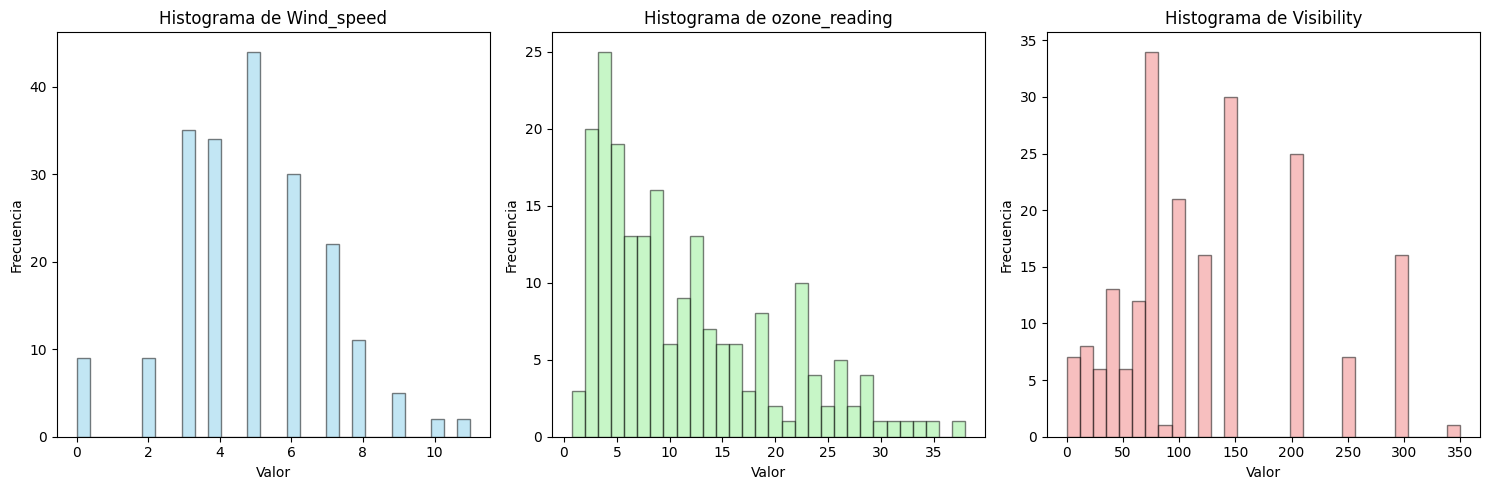

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

for i, var in enumerate(variables):
    histograma(var, df[var], colors[i], axs[i])

plt.tight_layout()
plt.show()

# **Rango Intercuartilico**
La función `rangoIntercuartilico_borrar` es diseñada para **identificar outliers** dentro de un conjunto de datos basándose en el **método del rango intercuartílico (IQR)**. Comienza calculando el primer y tercer cuartil (Q1 y Q3) del conjunto de datos, los cuales representan respectivamente el 25% y el 75% de los datos ordenados. A partir de estos, el IQR se determina como la diferencia entre Q3 y Q1, proporcionando una medida de la dispersión central de los datos. Utilizando el IQR, se establecen los límites para detectar outliers: el límite inferior es Q1 menos 1.5 veces el IQR, y el límite superior es Q3 más 1.5 veces el IQR. Valores fuera de estos límites se consideran atípicos o outliers. La función finalmente imprime y retorna estos límites para la variable en cuestión. Este enfoque es particularmente valioso para distribuciones no simétricas o con colas pesadas, ya que el IQR es menos susceptible a outliers que métodos basados en la media y la desviación estándar.

In [37]:
# GRAFICA PARA LINEAS DE OUTLIERS EN EL TIMEPO Y DESPUES PARA CALCULAR OUTLIERS

def rangoIntercuartilico_borrar(var,dfMini):
  # Calcular Q1, Q3 y IQR
  Q1 = dfMini.quantile(0.25)
  Q3 = dfMini.quantile(0.75)
  IQR = Q3 - Q1

  # Definir los límites para los outliers
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR
  print(f'\n{var}: límite inferior es {limite_inferior} y cuyo límite superior es {limite_superior}')
  return limite_inferior, limite_superior


**GRÁFICA DE LÍNEAS de las variables estudiadas en función del tiempo**

Se emplean gráficas de líneas para observar si hay anomalías temporales en las variables, ya que estos son especialmente efectivos para mostrar cómo una variable cambia con el tiempo.


1. **Wind_speed**:
   - No se observa una tendencia estacional clara en las velocidades del viento. Las fluctuaciones son frecuentes y no parecen seguir un patrón que corresponda a cambios estacionales. Sin embargo, uno de los dos picos que se pueden observar pertenece al mes de marzo, el cual representa el mes con más viento en gran parte de España.

2. **Ozone_reading**:
   - Aunque las gráficas no muestran una tendencia estacional clara debido a la variabilidad de los picos, es posible que los aumentos en las lecturas de ozono puedan estar relacionados con los meses más cálidos, ya que la formación de ozono a nivel del suelo es a menudo más intensa durante periodos de altas temperaturas. A mayor temperatura, mayor reactividad de esos precursores con la luz solar y con el calor, mayor formación de ozono.

3. **Visibility**:
   - La visibilidad muestra variabilidad significativa a lo largo del año. Sin embargo, se puede observar entre los meses de mayo y septiembre períodos con disminuciones notables y para el resto de meses valores más altos. Esto podría estar asociado con condiciones meterológicas características del invierno como podría ser la niebla o tormentas.


Además, se añade en cada gráfica una **recta roja** para marcar el límite superior y otra para el límite inferior definida por la función, de forma que se pueda observar mejor los outliers.

In [38]:
import matplotlib.pyplot as plt

def graficoLinea(var, df, colores, ax):
    ax.plot(df['fecha'], df[var], color=colores, linestyle='-')
    ax.set_title(f'Gráfico de {var}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel(f'{var}')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x para una mejor legibilidad

    # Agregar línea horizontal en los límites del eje y
    li, ls = rangoIntercuartilico_borrar(var,df[var])
    ax.axhline(y=ls, color='r', linestyle='--')  # Puedes personalizar el color y el estilo de la línea según tus preferencias
    ax.axhline(y=li, color='r', linestyle='--')




Wind_speed: límite inferior es -1.5 y cuyo límite superior es 10.5

ozone_reading: límite inferior es -12.1875 y cuyo límite superior es 33.0325

Visibility: límite inferior es -75.0 y cuyo límite superior es 285.0


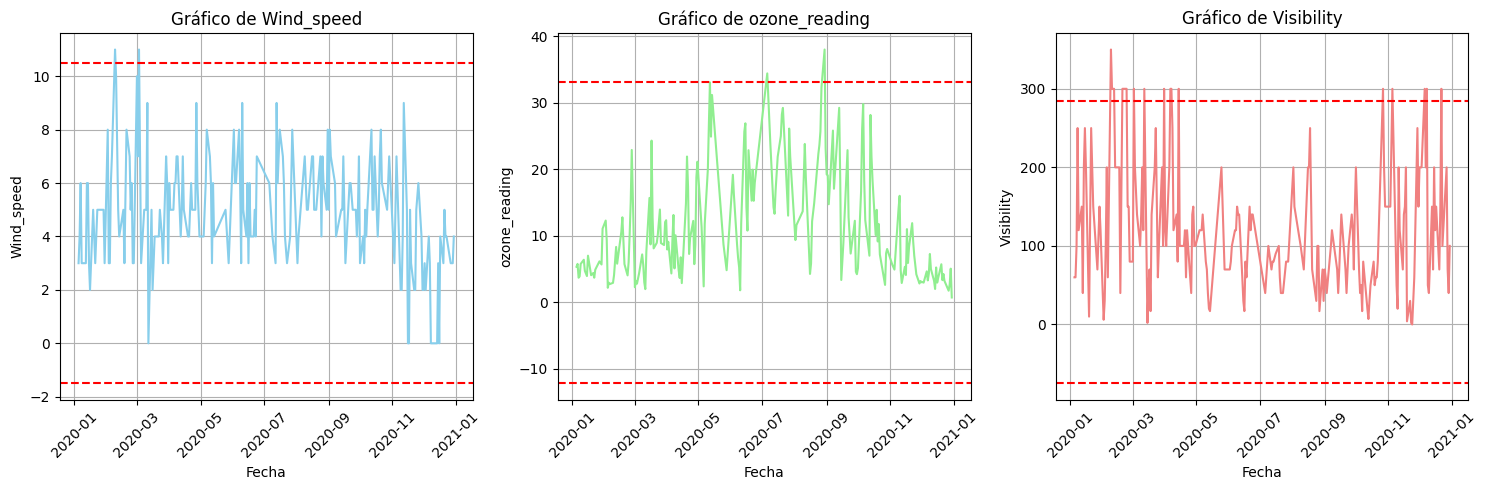

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

for i, var in enumerate(variables):
    graficoLinea(var, df, colors[i], axs[i])

plt.tight_layout()  # Ajustar automáticamente el diseño para evitar superposiciones
plt.show()

### **BoxPlot o gráfico de bigotes**

Para llevar a cabo este análisis, se ha optado por utilizar **gráficos de caja**, también conocidos como boxplots o gráfico de bigotes. Esta elección permite **visualizar la distribución de los datos a través de sus cuartiles**, resaltando no solo la mediana y los cuartiles, sino también los valores atípicos. Estos gráficos permiten identificar de manera rápida si los datos presentan una distribución simétrica, si están sesgados y si existen valores atípicos que podrían distorsionar el análisis o señalar fenómenos que se deberían estudiar.

Se genera un boxplot para cada una de las variables mencionadas, añadiendo un ligero "jitter" a los puntos de datos. Este **"jitter" evita la superposición** de los puntos, permitiendo una visualización más clara de cada observación individual.

El "jitter" mejora la legibilidad de los puntos de datos superpuestos o muy cercanos entre sí. Al añadir un pequeño **desplazamiento** aleatorio a la posición en el eje x de estos puntos (manteniendo inalterada su posición en el eje y que corresponde a su valor real), se evita la superposición y se facilita visualizar la cantidad y distribución de los datos que caen fuera o dentro de los rangos normales definidos por el boxplot. De esta forma, los valores reales de los datos no se ven alterados pero su visualización gráfica es más fácil. Además, así se evita que los puntos aparezcan como una única mancha o línea en el gráfico, dificultando la identificación de patrones o anomalías específicas.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def bigotes(variables, colors, df):
  plt.figure(figsize=(12, 8))

  for i, var in enumerate(variables, 1):
      # Contar el total de puntos para la variable actual
      total_points = len(df[var])
      print(f"Total de puntos para {var}: {total_points}")

      plt.subplot(1, len(variables), i)

      # Crear boxplot
      bp = plt.boxplot(df[var], patch_artist=True, positions=[i], boxprops=dict(facecolor=colors[i-1]))

      # Añadir puntos individuales
      y = df[var]
      x = np.random.normal(i, 0.04, size=len(y))  # Añade un poco de jitter a la posición x de los puntos
      plt.scatter(0.5 + x, y, alpha=0.7, color='black', s=10)  # s controla el tamaño de los puntos

      plt.title(var)
      plt.xticks(range(1, len(variables) + 1), variables)  # ajustar los ticks del eje x si es necesario

  plt.tight_layout()
  plt.show()

Total de puntos para Wind_speed: 203
Total de puntos para ozone_reading: 203
Total de puntos para Visibility: 203


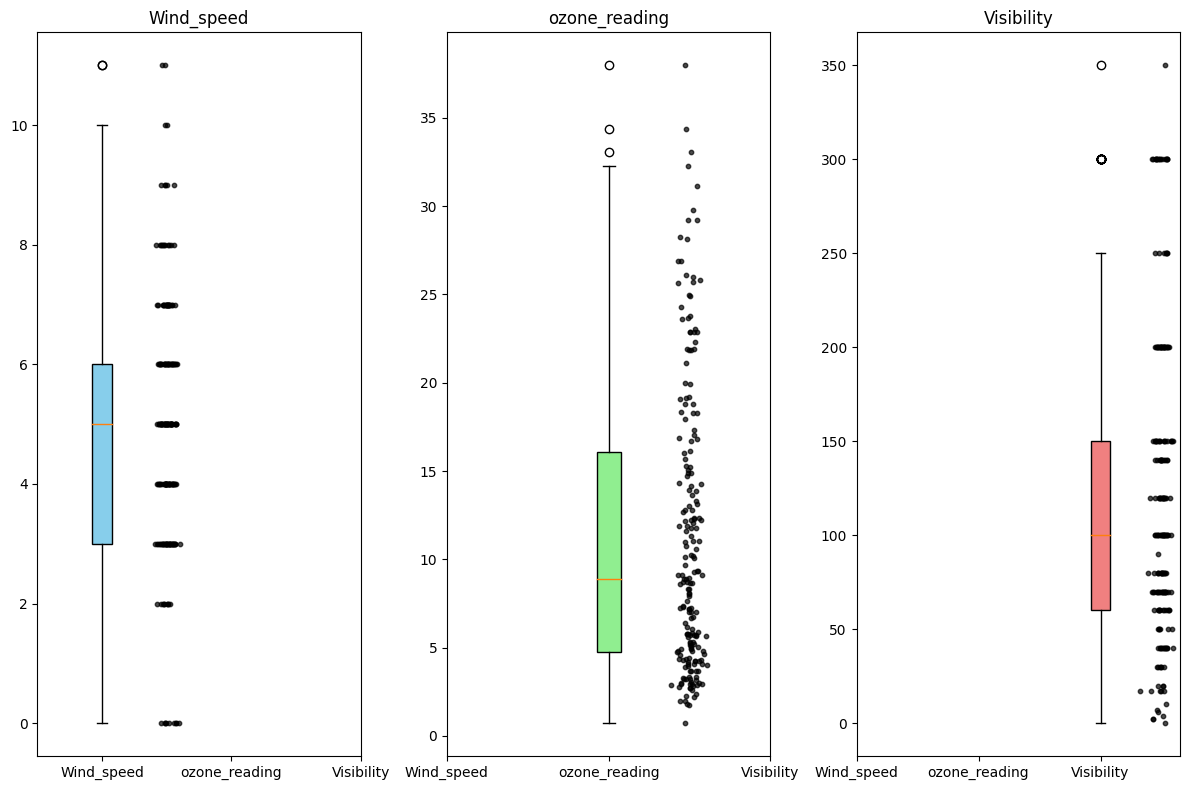

In [41]:
bigotes(variables, colors, df)

### **Conclusiones de los boxplot**

Analizando los tres boxplots, se puede observar que:

1. **Velocidad del viento (Wind_speed)**:
   - La mediana está alrededor de 5 (asumiendo que la unidad es m/s o una unidad estándar de velocidad del viento), lo que indica que la velocidad del viento media en el campus es moderada.
   - El rango intercuartílico (IQR), que va desde el borde inferior hasta el superior del box, no es muy amplio, sugiriendo que la mayoría de las mediciones de velocidad del viento se mantienen dentro de un rango estrecho.
   - Hay algunos outliers por encima del bigote superior, indicando ocasiones de vientos más fuertes que lo normal.

2. **Lectura de ozono (Ozone_reading)**:
   - La mediana de las lecturas de ozono es relativamente baja en comparación con el rango de los datos, lo que podría indicar que generalmente los niveles de ozono son bajos.
   - El IQR es estrecho, similar a la velocidad del viento, lo que sugiere una variabilidad baja en la mayoría de las mediciones.
   - A diferencia de la velocidad del viento, hay una gran cantidad de outliers para las lecturas de ozono. Esto indica la presencia de varios eventos donde las concentraciones de ozono han sido significativamente más altas que lo típico, las cuales pueden ser perjudiciales.

3. **Visibilidad (Visibility)**:
   - La mediana de la visibilidad está más alta que en las otras dos variables, lo que sugiere que en general se tiene una buena visibilidad.
   - El IQR es más amplio que en las otras dos variables, lo que implica una mayor variabilidad en las mediciones de visibilidad.
   - Existen outliers tanto en el extremo inferior como en el superior, lo que indica que hubo ocasiones de visibilidad excepcionalmente baja y alta. Sin embargo, no es muy extraño ya que la visibilidad puede verse afectada por una variedad de factores ambientales, incluyendo la contaminación, la niebla, la lluvia, etc.

4. **Otras consideraciones relacionadas con la época del año**:
   - Los patrones observados en `Ozone_reading` y `Visibility` podrían tener ciclos diarios o estacionales. Por ejemplo, los niveles de ozono suelen ser más altos durante las tardes de los meses cálidos debido a la química atmosférica que necesita luz solar. La visibilidad podría disminuir durante las mañanas debido a la niebla, que es más común en ciertas estaciones.

Para establecer relaciones entre estas variables, se va a realizar posteriormente un análisis estadístico más profundo incluyendo su correlación.

Por otra parte, el rango intercuartílico (IQR), el cual abarca el 50% central de los datos y es dividido en dos partes iguales por la mediana (Q2), es una representación de la variabilidad mediante cajas. En el boxplot, aquellos **valores que se salgan** del borde inferior de la caja, que indica el primer cuartil (Q1), o del borde superior de la caja, que indica el tercer cuartil (Q3) se consideran outliers.

### **Información analítica del BoxPlot**

Por otro lado, se proporcionan estadísticas descriptivas, mediante el **método describe**, que resumen la **tendencia central y la dispersión del conjunto de datos**, con valores como el número de observaciones no nulas (count), la media (mean), la desviación estándar (std), valores mínimos y máximos, y los cuartiles (Q1 = 25%, Q2= 50%, Q3 = 75%)

En general, estos resultados muestran que ozone_reading y Visibility tienen una variabilidad significativamente más alta que Wind_speed, como se refleja en sus desviaciones estándar más altas. Además, la distribución de las lecturas de ozono está sesgada hacia valores más bajos, con algunos valores extremadamente altos que actúan como outliers, mientras que la visibilidad muestra una amplia gama de condiciones, desde cero (sin visibilidad) hasta 350 unidades (condiciones muy claras).

Mirando los datos más detalladamente, podemos observar que la **velocidad del viento** (`Wind_speed`), con 203 registros, tiene una velocidad media de aproximadamente 4.87, con una variabilidad moderada (desviación estándar de 2.10) y valores que varían desde la calma total (0) hasta ráfagas considerables (máximo de 11). Las **lecturas de ozono** (`ozone_reading`) también presentan 203 observaciones y muestran una mayor variabilidad (desviación estándar de 8.19), con una media de 11.37 y picos que alcanzan hasta 37.98, lo que sugiere episodios ocasionales de alta concentración de ozono. La **visibilidad** (`Visibility`) destaca por su alta dispersión (desviación estándar de 81.17), con una mediana de 100 que indica condiciones generalmente claras, pero con extremos que van desde cero, posiblemente debido a condiciones meteorológicas adversas, hasta una visibilidad excepcional de 350.


Por lo tanto, mientras que la **velocidad del viento** mantiene una **consistencia** relativa con menos variación extrema, tanto las lecturas de **ozono** como las de **visibilidad** experimentan **fluctuaciones** significativas, lo que podría reflejar la influencia de factores ambientales o eventos que afectan a estas mediciones.

In [42]:
print(df[variables].describe())

       Wind_speed  ozone_reading  Visibility
count  203.000000     203.000000  203.000000
mean     4.866995      11.373990  122.197044
std      2.105402       8.192652   81.171317
min      0.000000       0.720000    0.000000
25%      3.000000       4.770000   60.000000
50%      5.000000       8.900000  100.000000
75%      6.000000      16.075000  150.000000
max     11.000000      37.980000  350.000000


## **Análisis de Outliers**


En vez de determinar la cantidad de outliers que hay en cada variable según los rangos asignados por defecto en el boxplot graficado, se calculará estadísticamente los rangos que se emplearán para obtener los outliers mediante la función `rangoIntercuartilico`.

Por lo tanto, si los datos se encuentran dentro de los límites calculados a partir del IQR, se asumen como parte de la variabilidad esperada en la distribución de los datos. Aunque visualmente en el boxplot aparecen fuera de la caja, no se les etiqueta como outliers si no cruzan esos límites. Esto ayuda a evitar la eliminación excesiva de datos que pueden ser extremos pero aún así son legítimos, especialmente en distribuciones que no son simétricas.

Una vez analizados los outliers, se debe **decidir qué hacer con ellos**. Se entiende que los valores atípicos **no representan situaciones que no sean posibles en la realidad**, ya que como se ha podido observar, coinciden los outliers con la época del año donde son más comúnes los valores extremos. Además, se ha podido comprobar que los outliers no son totalmente diferentes o aislados. Por lo tanto, se mantendrán a lo largo del análisis.




In [43]:
for i in variables:
  li,ls = rangoIntercuartilico_borrar(i,df[i])
  outliers_count = df[(df[i] < li) | (df[i] > ls)].shape[0]
  print(f'Hay {outliers_count} outliers para la variable {i}')


Wind_speed: límite inferior es -1.5 y cuyo límite superior es 10.5
Hay 2 outliers para la variable Wind_speed

ozone_reading: límite inferior es -12.1875 y cuyo límite superior es 33.0325
Hay 3 outliers para la variable ozone_reading

Visibility: límite inferior es -75.0 y cuyo límite superior es 285.0
Hay 17 outliers para la variable Visibility


# **Intersección y unión**

Para estudiar la intersección y la unión de outliers entre las variables "Wind_speed" y "Visibility", se calcula incialmente los outliers para cada una de estas variables. Esto permite encontrar los casos donde los datos son outliers tanto en "Wind_speed" como en "Visibility" (**intersección**), así como todos los puntos de datos que son outliers en ambas (**unión**).

El análisis de la unión e intersección de valores atípicos (outliers) en variables climáticas como la visibilidad ("visibility") y la velocidad del viento ("wind_speed") puede ser muy útil por varias razones:
1. **Identificación de Eventos Extremos**
  - **Unión de Outliers**: Al estudiar la unión de outliers en ambas variables, se identifican todos los eventos extremos que afectan al menos una de las condiciones climáticas. Esto es útil para entender la frecuencia y la magnitud de eventos extremos, como tormentas o neblinas densas, que podrían influir en la visibilidad y/o en la velocidad del viento.
  - **Intersección de Outliers**: La intersección, por otro lado, revela los casos donde ambas variables exhiben comportamientos atípicos simultáneamente. Esto podría señalar eventos climáticos específicos que son especialmente severos, afectando múltiples aspectos del clima a la vez.

2. **Comprensión de Relaciones y Dependencias**
  - Analizar cómo se relacionan los outliers entre estas dos variables puede ayudar a entender si existe una dependencia o correlación entre la visibilidad y la velocidad del viento durante condiciones climáticas extremas. Por ejemplo, altas velocidades de viento podrían estar asociadas con baja visibilidad durante tormentas de arena o nieve.

In [44]:
# Definir una función para calcular los outliers
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]
    return outliers

# Calcular outliers para 'Wind_speed' y 'Visibility'
wind_speed_outliers = calculate_outliers(df['Wind_speed'])
visibility_outliers = calculate_outliers(df['Visibility'])

# Encontrar la intersección de outliers
intersection_outliers = wind_speed_outliers.index.intersection(visibility_outliers.index)

# Encontrar la unión de outliers
union_outliers = wind_speed_outliers.index.union(visibility_outliers.index)

print("Número de outliers en la intersección:", intersection_outliers.size)
print("Número de outliers en la unión:", union_outliers.size)
print("Registros de datos que forman la intersección o la unión")
display(intersection_outliers)
display(union_outliers)

Número de outliers en la intersección: 1
Número de outliers en la unión: 18
Registros de datos que forman la intersección o la unión


Int64Index([22], dtype='int64')

Int64Index([22, 23, 24, 28, 29, 30, 35, 36, 42, 54, 58, 59, 64, 162, 166, 185,
            187, 197],
           dtype='int64')

A continuación, se muestran los registros que pertenecen a la intersección y unión de manera individual de las variables estudiadas. De esta forma, se podrá confirmar que los valores obtenidos previamente son correctos.

In [45]:
print('Intersección')
display(df[(df['Visibility'] > 285) & (df['Wind_speed'] > 10.5)].head(100))

print('Unión')
display(df[(df['Visibility'] > 285) | (df['Wind_speed'] > 10.5)].head(100))

Intersección


,Month,Day_of_month,Day_of_week,ozone_reading,pressure_height,Wind_speed,Humidity,Temperature_Sandburg,Temperature_ElMonte,Inversion_base_height,Pressure_gradient,Inversion_temperature,Visibility,fecha
22,2,9,1,2.92,5490,11,72,37,38.48,5000,32,38.12,350,2020-02-09


Unión


,Month,Day_of_month,Day_of_week,ozone_reading,pressure_height,Wind_speed,Humidity,Temperature_Sandburg,Temperature_ElMonte,Inversion_base_height,Pressure_gradient,Inversion_temperature,Visibility,fecha
22,2,9,1,2.92,5490,11,72,37,38.48,5000,32,38.12,350,2020-02-09
23,2,10,2,4.08,5560,10,72,41,40.46,5000,-1,37.58,300,2020-02-10
24,2,12,4,8.32,5680,5,50,51,47.12,5000,-8,45.50,300,2020-02-12
28,2,20,5,5.73,5690,8,21,41,43.88,5000,-30,42.26,300,2020-02-20
29,2,23,1,4.04,5690,7,19,53,50.18,5000,7,49.10,300,2020-02-23
30,2,24,2,6.04,5640,5,68,50,37.40,5000,24,42.08,300,2020-02-24
35,3,2,2,3.22,5470,7,46,30,29.66,5000,44,29.30,300,2020-03-02
36,3,3,3,2.79,5320,11,45,25,27.68,5000,39,27.50,200,2020-03-03
42,3,12,5,7.63,5690,0,60,49,46.04,613,-27,59.72,300,2020-03-12
54,3,31,3,12.33,5710,3,46,62,52.52,472,34,62.96,300,2020-03-31


### **Observación del outlier de la intersección**

Observando el registro de la intersección, se observa que no solamente es un valor atípico en las variables estudiadas, sino que también tiene outliers en el valor del ozono, al tener un valor bajo comparado con el resto. Por otra parte, la variable inversion base height presenta un valor atípico extremadamente alto, aunque algo más común. Por tanto, se puede concluir que cuando un registro contiene varios outliers, este registro tendrá mayor probabilidad de contener otros valores atípicos a parte de en esa variable.  

### **Observación outliers de la unión**
La mayoría de outliers se encuentran en los meses de febrero, marzo y abril, representando la época de primavera, así como en los meses de octubre, noviembre y diciembre, siendo estos otoño. El hecho de que estos valores sean mayores en estas estaciones se puede deber a varios factores:

  - **Frentes Meteorológicos Activos**: La primavera a menudo ve un aumento en la actividad de frentes meteorológicos debido a la interacción entre masas de aire frío remanentes del invierno y masas de aire cálido que se mueven hacia el norte. Estos frentes pueden generar vientos fuertes y despejar el cielo, mejorando la visibilidad.

  - **Transición Climática**: La primavera es una estación de transición, caracterizada por el cambio de condiciones frías a más cálidas. Este cambio induce variaciones en la presión atmosférica, lo que puede aumentar la velocidad del viento.

# **Categorización**

La categorización de variables es un proceso crucial en análisis de datos y modelado estadístico, donde variables continuas o numéricas se transforman en un número limitado de categorías o grupos discretos. Este proceso simplifica los datos, facilitando su análisis e interpretación, especialmente útil para visualizaciones o para comprender comportamientos de variables. La categorización también ayuda a mitigar la influencia de outliers, ya que estos se agrupan en categorías amplias, reduciendo su impacto individual. Este enfoque también puede **revelar relaciones no lineales** entre variables y cómo diferentes variables interactúan entre sí simplificando la información, ofreciendo perspectivas valiosas que podrían no ser evidentes con datos continuos. Sin embargo, la **categorización** conlleva desafíos, como la **pérdida de información y precisión**, y la **selección de límites** de categoría puede afectar significativamente los resultados del análisis, lo que requiere cuidadosa consideración.

Para ello, lo primero que se debe realizar es la elección de las variables que se van a categorizar.

**Elección de las variables a categorizar**

Para seleccionar las variables que mejor nos permitan observar si proporcionan información de manera continua o discreta, así como para identificar cómo interactúan entre sí, utilizaremos un criterio el cual se centra en la **capacidad de las variables para proporcionar información de forma continua o discreta**. Esto significa que se buscarán aquellas variables que muestren una amplia gama de valores a lo largo del tiempo, lo que sugiere una naturaleza continua de la información que representan, en este caso se tratarán inversion_temperature y temperatura_elMonte para comprobar su relación, y visualizarla de forma más simple. Al mismo tiempo, también se considerarán variables que muestren variaciones más abruptas o distintos grupos de valores, lo que indica una naturaleza más discreta, como visibility y wind_speed.

Para llevar a cabo este proceso sin modificar el conjunto de datos original, crearemos **copias de las variables relevantes**. Estas copias nos permitirán realizar análisis e iteraciones entre ellas sin comprometer el conjunto de datos original y facilitarán la **exploración** de diferentes enfoques analíticos **sin riesgo de pérdida de datos**.

In [46]:
data_clase = df.copy()

### Analisis de las variables discretas

Para comenzar, se tomará el número de **elementos únicos** que posee cada variable. Estos elementos representan el máximo de categorías que la variable aceptará de manera lógica.

In [47]:
for i in column_names:
  print(f'Número de clases en:',i, '-->', len(data_clase[i].unique()))

Número de clases en: Month --> 12
Número de clases en: Day_of_month --> 31
Número de clases en: Day_of_week --> 5
Número de clases en: ozone_reading --> 194
Número de clases en: pressure_height --> 48
Número de clases en: Wind_speed --> 11
Número de clases en: Humidity --> 60
Número de clases en: Temperature_Sandburg --> 58
Número de clases en: Temperature_ElMonte --> 137
Número de clases en: Inversion_base_height --> 125
Número de clases en: Pressure_gradient --> 106
Número de clases en: Inversion_temperature --> 145
Número de clases en: Visibility --> 23


A partir de este punto, ya hemos determinado qué variables tienen una estructura continua y cuáles son discretas. Teniendo en cuenta que contamos con 203 registros, las variables como **Month, Day_of_month, Day_of_week, Wind_speed o Visibility** son claramente **discretas** debido a su bajo número de clases. Sin embargo, estas variables están registradas como numéricas en nuestra base de datos, por lo que procederemos a categorizarlas para mejorar su relación y ver cómo interactuan con otras variables. Además, nos centraremos en **Wind_speed** o **Visibility** al poder categorizarse en **grupos más reducidos agrupando la infromación**.

Por otro lado, en las variables continuas nos centraremos en **temperatura_elMonte** e **inversion_temeprature** las cuales como podremos observar más adelante en la matriz de correlación, están directamente **correlacionadas** con ello podremos observar y comprobar su relación de forma más sencilla observando como interactua cada categoría. Las variables continuas al distribuirse de diversas formas como observamos al principio será necesario categorizarlas en base a valores teóricos que hemos estudiado y explicaremos a continuación.

Para comenzar, analizaremos cada una de las categorías básicas de estas variables.

La categorización de Wind_speed no es pura, sino que son diferentes mediciones iguales de una variable que debería de ser continua. Esto puede ser debido a aproximaciones de medición. Por este motivo esta variable puede ser categorizada en **clases alternativas**.

In [48]:
data_clase['Wind_speed'].unique()

array([ 3,  4,  6,  2,  5,  8,  7, 11, 10,  9,  0])

Del mismo modo que Wind_speed, la categorización de Visibility no es pura, sino una agrupación de registros continuos. Además, en este caso, emplear una categorización alternativa es más importante debido al **alto número de clases** que posee la variable.

In [49]:
data_clase['Visibility'].unique()

array([ 60, 100, 250, 120, 150,  40, 200,  10,  70,   6,  30, 350, 300,
        80, 140,   2,  50,  17,  20,  90,   7,   4,   0])

### **Categorización de las variable discretas seleccionadas**

Categorizamos las variables que poseen una **categorización pura**, es decir, que su categorización es la usual como serían los 12 meses, los 31 días del mes o los 5 días laborables de la semana.

In [50]:
data_clase['Month'] = data_clase['Month'].astype('category')
data_clase['Day_of_week'] = data_clase['Day_of_week'].astype('category')
data_clase['Day_of_month'] = data_clase['Day_of_month'].astype('category')

Las variables que no han sido seleccionadas como puras seran categorizadas en **4 categorias**. Para ello se calcularan los intervalos de manera en la que haya un número parecido de elementos en cada una de las categorias.

In [51]:
def categorizacion4categorias(data_clase, nombre):
  conteo = data_clase[nombre].value_counts().sort_index(ascending=True)
  limite = data_clase[nombre].count() / 4
  c = 1
  intervalo = []

  for i in range(len(conteo)):
    if sum(conteo[0:i]) > c*limite:
      intervalo.append(conteo.index[i])
      c += 1

  etiquetas = ['Muy baja', 'Baja', 'Moderada', 'Alta']
  data_clase[nombre] = pd.cut(data_clase[nombre], bins=[-1] + intervalo + [np.inf], labels=etiquetas, right=False)

In [52]:
categorizacion4categorias(data_clase, 'Visibility')
categorizacion4categorias(data_clase, 'Wind_speed')

### **Categorización de las variable continuas seleccionadas**

En el caso de variables continuas, la categorización se realiza teóricamente utilizando información sobre las características típicas de los datos, considerando las unidades de medida en lugar de simplemente las clases. A diferencia de la categorización discreta, donde los rangos de las variables pueden no ser completamente conocidos, en las variables continuas se utilizan categorías basadas en conocimientos previos sobre cómo suelen distribuirse los datos.

**Temperature_ElMonte:** del aire o de cualquier otro medio que rodea los componentes de un sistema térmico.

* Muy Baja: Rango 30 - 40. Temperaturas que se sienten extremadamente frías (inferiores al percentil 10 para la región y período del año) para la mayoría de las personas.  
* Baja: Rango 40 - 50. Temperaturas frescas que pueden requerir capas adicionales de ropa. Entre el percentil 10 y 25, caracterizando condiciones frescas por debajo de la media.
* Media: Rango 50 - 66. Rango confortable para actividades diarias. Temperaturas en el rango intercuartílico (percentil 25 al 75), representando las condiciones típicas esperadas.
* Alta: Rango 66 - 83. Calor intenso. Temperaturas superiores al percentil 75, señalando condiciones más cálidas de lo normal.


**Inversion_temperature:** es un fenómeno meteorológico en el que la temperatura del aire aumenta con la altitud, contrario al patrón normal (gradiente térmico negativo) donde la temperatura disminuye con la altura.
  
  * Inversión Leve: Rango 31 - 50. Pequeño aumento, efecto mínimo en la dispersión de contaminantes.
  * Inversión Moderada: Rango 50 - 71. Aumento moderado, restringe la dispersión de contaminantes.
  * Inversión Fuerte: Rango 71 - 91. Aumento significativo de temperatura con la altitud, provoca una fuerte restricción en la dispersión de contaminantes y puede llevar a alta contaminación.

In [53]:
# Variables apartado 3
variables = ['Temperature_ElMonte', 'Inversion_temperature']

**Categorizar variables**

A continuación se describe un método para **categorizar variables continuas**, a través de la función **`categorizador`**. Esta función toma como parámetros los límites de cada categoría (`bins`), las etiquetas para dichas categorías (`etiquetas`), el DataFrame a modificar (`data_clase`), y el nombre de la variable a categorizar (`var`). Utiliza la función `pd.cut` de pandas para **dividir y asignar las variables continuas a las categorías** definidas por `bins`, etiquetando cada categoría según se especifica en `etiquetas`.

El proceso comienza con la definición de los `bins`, que son **listas de valores que marcan los límites** entre las categorías para cada variable. Se hace una copia del DataFrame original (`df`) para evitar modificar los datos originales. Luego, mediante un bucle que recorre las variables enumeradas y sus correspondientes `bins`, se aplica la función `categorizador` a cada variable. Esta función ajusta el DataFrame `data_clase`, categorizando la variable en cuestión según los rangos definidos y asignándole las etiquetas correspondientes. El número de etiquetas es determinado dinámicamente para coincidir con el número de categorías creadas por los `bins` (el número de `bins` menos uno).

In [54]:
def categorizador (bins, etiquetas, data_clase, var):
  data_clase[var] = pd.cut(data_clase[var], bins=bins, labels=etiquetas)
  return data_clase

In [55]:
bins = [[-np.inf,40,50,66,np.inf],[-np.inf,50,71,np.inf]]

for i, var in enumerate(variables):
  data_clase = categorizador (bins[i], range((len(bins[i])-1)), data_clase, var)

In [56]:
import pandas as pd

for i, var in enumerate(variables):
  conteo_categorias = data_clase[var].value_counts()
  conteo_ordenado = conteo_categorias.reindex(range((len(bins[i])-1)))
  print(var)
  print(conteo_ordenado)

  # Convertir en formato númerico para que no nos den problemas en futuras comprobaciones
  data_clase[var] = data_clase[var].astype('int64')

Temperature_ElMonte
0    20
1    35
2    96
3    52
Name: Temperature_ElMonte, dtype: int64
Inversion_temperature
0     45
1    108
2     50
Name: Inversion_temperature, dtype: int64


## **Análisis de las varibales seleccionadas**

Para comprobar las relaciones tanto de las variables discretas y continuas categorizadas, utilizaremos las gráficas de bloques subdividadas por las categorías de las variables seleccionadas.

In [57]:
def frecuenciaDosVar(df, var1,var2):

  # Primero, agrupamos por 'Wind_speed' y 'Inversion_temperature' y contamos las ocurrencias
  df_grouped = df.groupby([var1, var2]).size().unstack(fill_value=0)

  # Preparar los datos para el gráfico de barras apiladas
  fig, ax = plt.subplots()

  # Las categorías de temperatura de inversión
  categories = df_grouped.columns

  # Base para apilar las barras
  bottom = np.zeros(len(df_grouped))

  for category in categories:
      ax.bar(df_grouped.index, df_grouped[category], bottom=bottom, label=category)
      bottom += df_grouped[category].values

  ax.set_xlabel(f'{var1}')
  ax.set_ylabel(f'Frecuencia de {var2}')
  ax.set_title(f'Frecuencia de {var1} frente a {var2}')
  ax.legend()

  plt.show()

Analizaremos la variable visibility en relación con los meses.

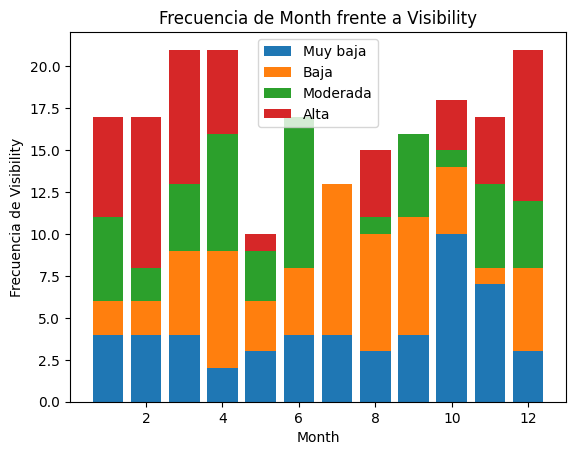

In [58]:
frecuenciaDosVar(data_clase, 'Month','Visibility')

En la matriz de correlación se puede observar que entre "Month" y "Visibilidad" no había una relación lineal. Pero gracias a este gráfico de barras se puede apreciar cómo la visibilidad cambia dependiendo del mes en el que se esté. En invierno, especialmente desde diciembre hasta marzo, son los meses con mayor visibilidad, mientras que los meses de verano como junio, julio o septiembre tienen una peor visibilidad.

Analizaremos la variable viento en relación con los meses.

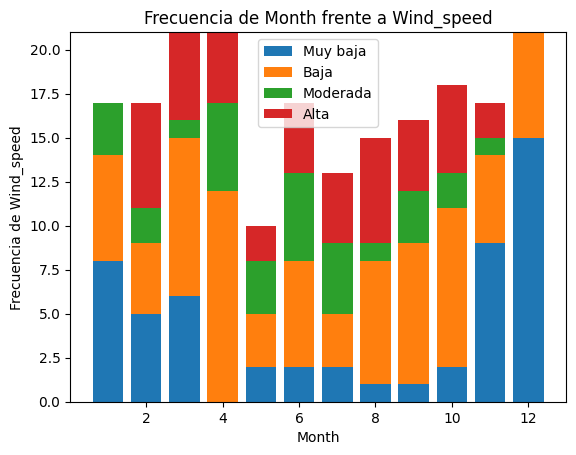

In [59]:
frecuenciaDosVar(data_clase, 'Month','Wind_speed')

De manera similar a la visibilidad, "Month" y "Wind_speed" no poseen una relación lineal, pero sí existen diferentes registros de viento influenciados según el mes. Los meses de invierno, como diciembre y enero, son los que tienen menos viento, mientras que el inicio de la primavera, desde febrero hasta abril, son los meses con un mayor índice de viento, seguramente provocado por las tormentas y lluvias que coinciden al final del invierno y al principio de la primavera.

Analizamos la frecuencia de Temperature_ElMonte frente a Inversion_temperature

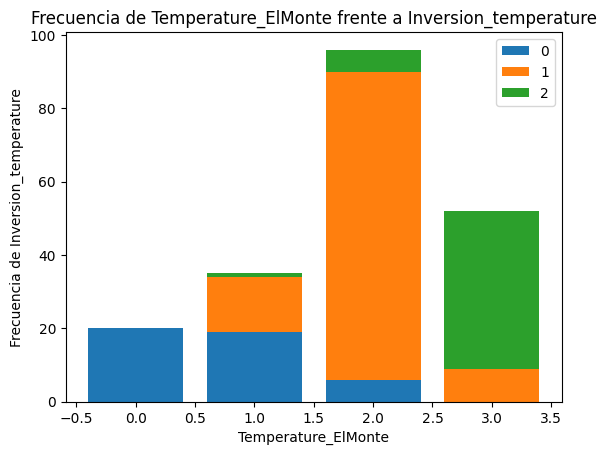

In [60]:
frecuenciaDosVar(data_clase, 'Temperature_ElMonte', 'Inversion_temperature')

   - En esta gráfica, la categoría `2` de `Inversion_temperature` es particularmente dominante en la categoría más alta de `Temperature_ElMonte`, lo que podría sugerir que temperaturas más altas en El Monte están asociadas con un determinado rango de temperaturas de inversión.
   - Las categorías `0` y `1` de `Inversion_temperature` tienen una presencia más significativa en categorías más bajas de `Temperature_ElMonte`, lo cual indica que temperaturas más bajas en El Monte podrían estar asociadas con rangos más bajos de temperaturas de inversión. Constatando la relación directa que se observará en la matriz de correlación.

## **Conclusión del apartado 3:**
Gracias a la categorización de variables, se ha podido observar cómo se relacionan, confirmando intuiciones previas. Por ejemplo, al estudiar los outliers en visibilidad y velocidad del viento durante primavera y otoño en el aparatado 2, se nota una mejora en ambas variables debido a las tormentas y anticiclones. Ahora, se puede observar esa relación en no solo en términos de valor las cuales a veces son abruptas y puede conllevar mal interpretaciones, sino que a través de la frecuencia se ha reafirmado nuestra intuición.  Además, al comparar la tercera gráfica con la matriz de correlación del apartado 4, se confirma la alta correlación del 91%, lo que permite verificar esta relación de manera más clara tras la simplificación de datos.


# **Principales variables**

Para la elección de las variables principales a analizar sobre los días de medición se van a emplear dos técnicas complementarias: la **matriz de correlación** y los **modelos de árbol**.

### **Matriz de Correlación**

El análisis de correlación es un método inicial para identificar relaciones lineales entre variables. Se puede calcular el coeficiente de correlación de Pearson para cada par de variables, lo que dará una medida de la relación lineal entre cada variable predictora y la variable objetivo.

- Pros: **Fácil** de calcular y entender.
- Contras: **Solo capta relaciones lineales**; no detecta bien relaciones no lineales o complejas.

La matriz de correlación calcula los coeficientes que indican cómo cambian juntas las variables, con valores que oscilan entre -1 y 1. Un valor cercano a 1 señala una correlación positiva fuerte, mientras que cerca de -1 indica una correlación negativa fuerte, y alrededor de 0 indica una falta de correlación lineal. Esta información se visualiza mediante un mapa de calor, donde los colores representan la fuerza de la correlación entre las variables.

La utilidad de la matriz de correlación radica en proporcionar la **similitud de la información** ofrecida por dos variables. Si están altamente correlacionadas, la información será similar, lo que implica que no se necesitará emplear ambas para el análisis. Por lo tanto, es beneficioso **buscar variables poco correlacionadas** para **maximizar la información** utilizando el **menor número de variables posible**. Para facilitar la detección de variables altamente correlacionadas, se puede reorganizar la matriz **agrupando elementos con alta correlación**.

<ipython-input-61-11d155aa1a14>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(dists, method='average')


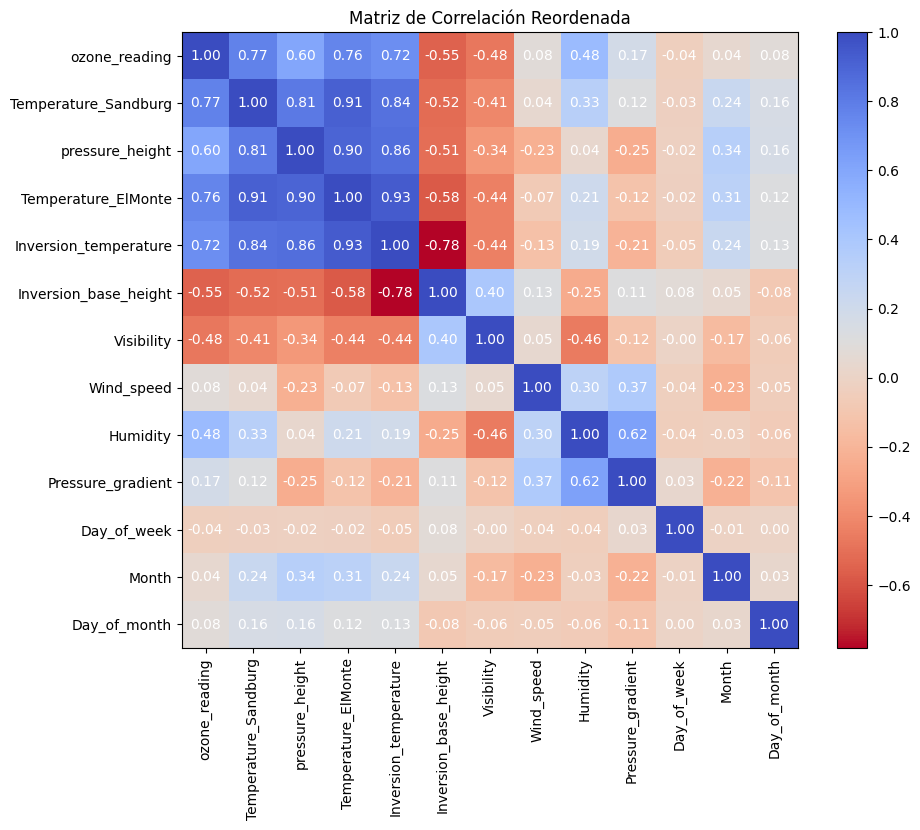

In [61]:
def plot_correlation_matrix(correlation_matrix):
    # Calculamos la matriz de distancia
    d = 1 - correlation_matrix
    # Convertimos la matriz de distancia en una matriz de similitud
    s = np.exp(-d ** 2 / 2)

    # Creamos una matriz de distancia euclidiana
    dists = np.sqrt((1 - s) / 2)

    # Aplicamos el algoritmo de ordenamiento jerárquico
    from scipy.cluster import hierarchy
    linkage_matrix = hierarchy.linkage(dists, method='average')
    idx = hierarchy.leaves_list(linkage_matrix)

    # Reordenamos la matriz de correlación y las etiquetas de las variables
    reordered_corr = correlation_matrix.iloc[idx, :]
    reordered_corr = reordered_corr.iloc[:, idx]

    # Mostramos la matriz de correlación reordenada con valores
    plt.figure(figsize=(10, 8))
    plt.imshow(reordered_corr, cmap='coolwarm_r', interpolation='none')
    plt.colorbar()
    plt.xticks(range(reordered_corr.shape[0]), reordered_corr.columns, rotation=90)
    plt.yticks(range(reordered_corr.shape[0]), reordered_corr.columns)
    plt.title('Matriz de Correlación Reordenada')

    # Agregamos los valores de correlación en cada celda
    for i in range(reordered_corr.shape[0]):
        for j in range(reordered_corr.shape[1]):
            plt.text(j, i, '{:.2f}'.format(reordered_corr.iloc[i, j]), ha='center', va='center', color='white')

    plt.show()

# Suponiendo que df es tu dataframe con los datos y ya tienes la matriz de correlaciones
#correlation_matrix = df.corr()
correlation_matrix = df.drop('fecha', axis=1).corr()

# Utilizamos la función para graficar la matriz de correlación reordenada
plot_correlation_matrix(correlation_matrix)

**Conclusiones matriz de correlación**

1. **Temperatura**:
   - Las variables `Temperature_Sandburg` y `Temperature_ElMonte` tienen una alta correlación positiva entre sí (0.91), lo que indica que las temperaturas registradas en estas dos ubicaciones tienden a moverse juntas de manera muy similar.
   - Ambas temperaturas también muestran una correlación positiva significativa con `ozone_reading`, lo que confirma el razonamiento previo de que los niveles más altos de ozono pueden estar asociados con temperaturas más altas.

2. **Presión Atmosférica**:
   - `pressure_height` muestra una correlación positiva alta con `Temperature_Sandburg` y `Temperature_ElMonte` (0.81 y 0.90 respectivamente), lo que podría indicar que una mayor altura de la columna de presión se asocia con temperaturas más altas.
   - También hay una correlación negativa entre `pressure_height` e `Inversion_temperature` (-0.52), lo que sugiere que una mayor altura de la columna de presión podría estar asociada con menores gradientes de temperatura de inversión.

3. **Inversión Térmica**:
   - `Inversion_temperature` es un tipo de característica que toma la atmósfera cuando la temperatura del aire, en vez de descender mientras subimos en altura, como es normal, va ascendiendo cada vez más. Esta variable tiene una correlación positiva fuerte con `ozone_reading` (0.72), lo que podría indicar que las condiciones de inversión térmica tienden a estar asociadas con concentraciones más altas de ozono, lo cual tiene sentido debido a que el nivel de ozono suele ser más alto a mayor temperatura.


4. **Visibilidad**:
   - La visibilidad tiene una correlación negativa moderada con `Inversion_base_height` (-0.48) y `Inversion_temperature` (-0.44), lo que podría sugerir que las condiciones de inversión térmica afectan negativamente la visibilidad, probablemente debido a la acumulación de contaminantes cerca del suelo.

5. **Variables Temporales**:
   - Las variables temporales como `Month`, `Day_of_month` y `Day_of_week` tienen correlaciones generalmente bajas con las variables meteorológicas, indicando que no hay una relación lineal fuerte entre el tiempo del año o la semana y estas condiciones atmosféricas. Esto es razonable ya que las variables temporales por sí solas no causan cambios en las condiciones meteorológicas pero pueden estar asociadas con ciclos estacionales o patrones semanales.


Por otro lado, cuando analizamos las variables temporales **Day_of_week**, **Day_of_month** y **Month**, **no tienen ninguna relación lineal** con ninguna variable. Estas variables son las que hacen referencia a los días de medición y las que tendremos en cuenta en el análisis para encontrar nuevas relaciones.

También, se puede observar que las variables están asociadas en **tres grupos** según la información proporcionada. Ozone_reading, Temperature_Sandburg, Pressure_height, Temperature_ElMonte e Inversion_temperature son las cinco variables que forman el primer grupo. Inversion_base_height y Visibility forman el segundo grupo, el cual, aunque tiene algo de relación con el primer grupo, se considera que puede aportar nueva información. Finalmente, está el tercer grupo, formado por Wind_speed, Humidity y Pressure_gradient. Este grupo apenas tiene relación con los otros dos, por lo que nos proporcionará bastante información adicional para el análisis.

Nuestro objetivo para seleccionar las variables principales será escoger **una variable de cada uno** de los tres grupos, proporcionando así la información relevante de cada uno de ellos. Al escoger únicamente una, **evitaremos dar información repetida** durante el análisis, lo que será más efectivo. Para seleccionar qué variable emplear de cada uno de los grupos, se analizará cuál es la importancia de cada una de ellas sobre los meses de medición; la más importante será la seleccionada. Para realizar este proceso de selección, se emplearán los **Modelos de Árbol**.

### **Modelos de Árbol**

Los modelos de árbol, como los árboles de decisión, Random Forest y Gradient Boosting, pueden proporcionar medidas de la importancia de las características basadas en la contribución de cada característica a la mejora del modelo. Estas medidas suelen basarse en **cuánto contribuye cada variable** a reducir la impureza del nodo (por ejemplo, la ganancia de información) o en el aumento del rendimiento del modelo.

- Pros: **Capta relaciones no lineales** y la importancia de las interacciones entre variables.
- Contras: Más **complejo** de interpretar y puede ser propenso a sobreajustarse en el caso de árboles de decisión únicos.

Random Forest es un algoritmo de **aprendizaje supervisado**  ampliamente utilizado tanto para clasificación como para regresión. La idea clave detrás de Random Forest es **combinar las predicciones de múltiples árboles de decisión** para mejorar la precisión general de la variable Month y controlar el sobreajuste. Cada árbol se entrena en una muestra aleatoria de los datos con reemplazo (un método conocido como bagging o bootstrap aggregation) y utiliza un subconjunto aleatorio de las características en cada división. Esto hace que los árboles sean menos correlacionados entre sí, **aumentando la robustez** del modelo. De esta forma, al hacer el promedia de las predicciones de varios árboles, es **menos sensible al sobreajuste** que un único árbol de decisión.

Al ejecutar ramdomForest("Month",df) , la función **entrenará dos modelos** de Random Forest para predecir, respectivamente, el mes basándose en el resto de las características del DataFrame. Posteriormente, visualizará la importancia de cada característica en la predicción de estas variables objetivo, lo que puede ofrecer insights valiosos sobre los factores que influyen en la variabilidad temporal dentro de los datos. Para entrenar estos modelos, los datos se dividen en conjuntos de entrenamiento y prueba usando train_test_split, con un 20% de los datos reservados para prueba y el resto para entrenamiento, permitiendo evaluar el modelo en datos no vistos.



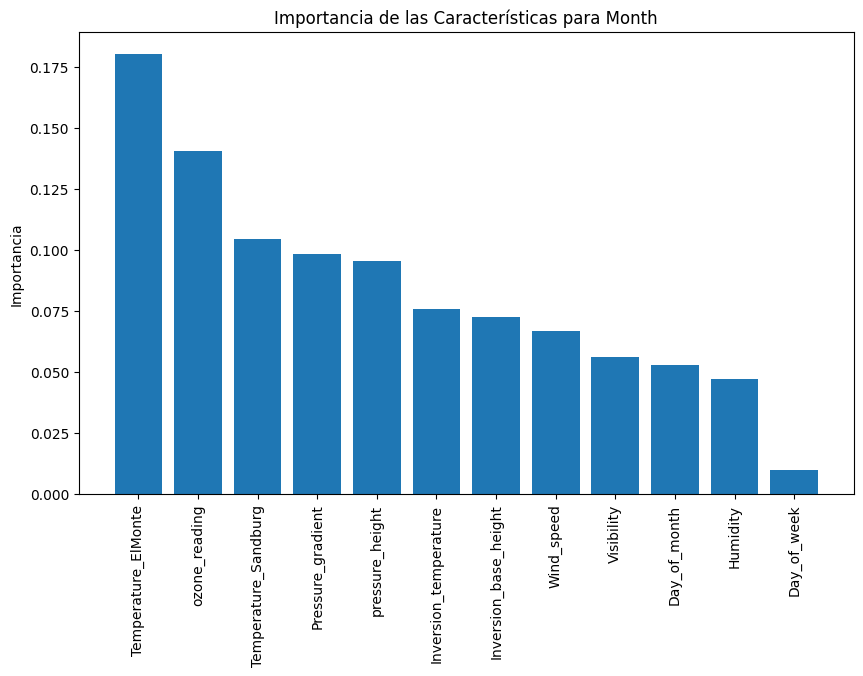

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split

def ramdomForest(var,data):
  data =  data.drop('fecha', axis=1)

  X = data.drop(var, axis=1) # Todas las variables excepto la objetivo
  y = data[var]  # Variable objetivo

  # Dividir los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  from sklearn.ensemble import RandomForestRegressor

  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)

  import matplotlib.pyplot as plt
  import numpy as np

  features = X.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)[::-1]

  # Visualizar la importancia de las características
  plt.figure(figsize=(10, 6))
  plt.title(f"Importancia de las Características para {var}")
  plt.bar(range(X_train.shape[1]), importances[indices], align="center")
  plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
  plt.xlim([-1, X_train.shape[1]])
  plt.ylabel("Importancia")
  plt.show()

ramdomForest("Month",df)

Cabe destacar que los resultados obtenidos muestran la importancia que posee cada variable sobre los meses, pero esta importancia **no es disjunta**. La importancia elevada, por ejemplo, de Temperature_ElMonte y de ozone_reading se debe a que poseen características de cambio similares, como se ha visto en la matriz de correlación. De esta manera, al seleccionar ambas variables, se daría una menor importancia en conjunto que la suma de sus importancias individuales.

Dentro del tercer grupo se ha seleccionado como variable principal a la que posee mayor importancia, la cual es **Pressure_gradient**. De acuerdo con el diagrama de árbol, Temperature_ElMonte e Inversion_temperature serían las variables más importantes, pero al analizar un poco más se observa que ozone_reading y Visibility tienen una importancia ligeramente inferior a sus contrapartes. La diferencia radica en que elegir **ozone_reading** y **Visibility** proporcionaría una gran ventaja en cuanto a la **información que aportan** en conjunto, ya que estas variables se encuentran en puntos opuestos (cada una en una esquina) dentro de la relación entre los grupos 1 y 2 de la matriz de correlación. Esto significa que son los elementos que **menos información comparten**. Por este motivo, aunque Temperature_ElMonte e Inversion_temperature tengan una importancia ligeramente mayor, se eligen ozone_reading y Visibility como representantes de sus grupos con el objetivo de evitar una posible redundancia de la información.

### **Representaciones continuas**


Realizaremos la representación de las variables continuas con respecto al tiempo para observar los valores que toman en cada momento. Esto nos permitirá comprobar la relación de las variables principales respecto al mes y comparar estas gráficas con las realmente importantes, que son las frecuencias en relación con cada mes de medición.

In [63]:
def graficoLineaMultiple(var, df, colores):
    # Crear el gráfico de línea
    plt.plot(df['fecha'], df[var], color=colores, linestyle='-', label=var)

    # Personalizar el gráfico
    plt.title('Gráfico Temporal')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)

In [64]:
# Variables principales a estudiar apartado 4
variables = ['ozone_reading', 'Pressure_gradient', 'Visibility']

# Colores
colors = ['skyblue', 'lightgreen', 'lightcoral']

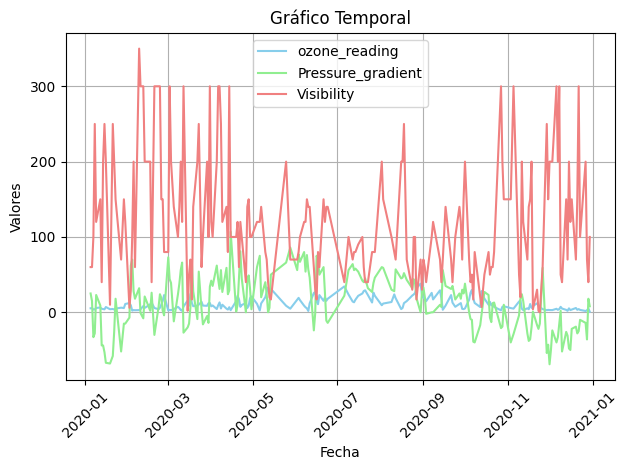

In [65]:
for i, var in enumerate(variables):
    graficoLineaMultiple(var, df, colors[i])

# Agregar leyenda
plt.legend()

# Ajustar el layout y mostrar el gráfico final
plt.tight_layout()
plt.show()

Las gráficas temporales son usadas para ver como fluctuan los valores de las varibles (ozone_reading, pressure_gradient y visibility) respecto al tiempo. En este caso, podemos observar que a más visbilidad, menos presión del gradiente y menor ozone reading. Esto puede ocurrir en períodos de estabilidad atmosférica, donde las diferencias de presión son menores, lo que resulta en menos viento y, por ende, en la acumulación de menos partículas en el aire que podrían reducir la visibilidad. Además, las condiciones que favorecen la alta visibilidad (como el aire frío y seco durante los meses de invierno) no son propicias para la formación de ozono, que a menudo requiere luz solar y precursores contaminantes específicos para formarse.

## **Frecuncias y distibución**

Las 3 variables principales para explicar el mes son: ozone_reading, Pressure_gradient y visbility. A continuación, se mostrará como se distribuyen cada una de ellas.



Pero antes de seguir avanzando se categorizará las variables ozone_reading y Pressure_gradient para poder calcular su frecuencia respecto a cada mes.

**ozone_reading**:
- ozone_reading se refiere a la concentración de ozono (O3) en la atmósfera en un lugar y momento específicos. Mientras que el ozono en la estratosfera protege la vida en la Tierra al filtrar la radiación ultravioleta (UV) del sol, el ozono a nivel del suelo es un contaminante que puede tener efectos perjudiciales para la salud humana, los ecosistemas y los materiales. El ozono a nivel del suelo no se emite directamente a la atmósfera; en cambio, se forma a través de reacciones químicas entre óxidos de nitrógeno y compuestos orgánicos volátiles en presencia de luz solar. Por lo tanto, las concentraciones de ozono a nivel del suelo tienden a ser más altas durante los meses de verano y en áreas con mucho sol.

- Bajo representa buena calidad del aire, moderado representa una calidad del aire aceptable y alto puede afectar a la salud de personas sensibles, aunque es menos probable que el público en general se vea influido.

  - Cantidad Muy Baja: Rango 0 - 3
  - Cantidad Baja: Rango 3 - 7
  - Cantidad Media: Rango 7- 12
  - Cantidad Alta: Rango 12 - 20
  - Cantidad MUy alta: Rango 20 - 40

**Pressure_gradient**:
- El "gradiente de presión" es una medida de la variación de la presión atmosférica a través de una distancia determinada. Se expresa generalmente en pascales por metro (Pa/m) o milibares por kilómetro (mb/km). Los gradientes de presión son una fuerza motriz fundamental detrás de los vientos y las corrientes de aire en la atmósfera. Un gradiente de presión fuerte indica una diferencia significativa de presión a través de una distancia corta, lo que suele resultar en vientos más fuertes.

- Un gradiente de presión débil indica una diferencia de presión pequeña a través de una gran distancia, asociado generalmente con vientos débiles, mientras que uno moderado indica una diferencia de presión notable que puede generar vientos moderados y uno fuerte indica una gran diferencia de presión a través de una distancia relativamente corta, asociado con vientos fuertes y posiblemente condiciones meteorológicas adversas.
  - Presión Alta: Rango 43 - 108
  - Presión Media: Rango 18 - 43.
  - No hay presión: Rango -14 - 18
  - Presión Baja: Rango -70 - -14.



In [66]:
variables = ['ozone_reading','Pressure_gradient']
bins = [[-np.inf,3,7,12,20,np.inf],[-np.inf,-14,18,43,np.inf]]
etiquetas = ['Muy baja', 'Baja', 'Moderada', 'Alta', 'Muy alta']

for i, var in enumerate(variables):
  data_clase = categorizador (bins[i], etiquetas[0:(len(bins[i])-1)], data_clase, var)

### **Representación frecuencias**

In [67]:
# Variables principales a estudiar apartado 4
variables = ['ozone_reading', 'Pressure_gradient', 'Visibility']

# Colores
colors = ['skyblue', 'lightgreen', 'lightcoral']

Para representar la frecuencia de las variables sobre los días de medición será esencial discretizar los 366 días del año disponibles. Para ello se aplicará la **discretización 'natural'**, dividiéndolos en los 12 meses del año. De esta forma, se tiene que la categorización ya está elaborada en la variable **Month**, por lo que se empleará esta para su análisis.

Análisis sobre el grupo 1: ozone_reading

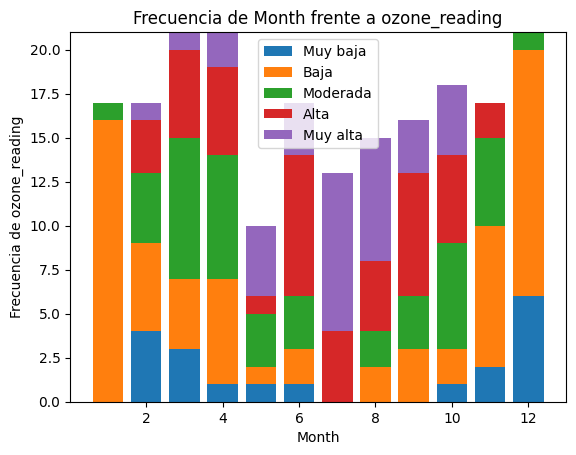

In [68]:
frecuenciaDosVar(data_clase, 'Month', variables[0])

Se puede apreciar que existe una relación entre ozone_reading y el mes. La relación (no lineal) nos muestra que el ozono es más alto especialmente en los meses de verano, como julio y agosto, y que es mucho más bajo en los meses de invierno, desde noviembre hasta enero. Esto se puede respaldar en el hecho de cómo influyen las altas temperaturas en la emisión de ozono, por lo que en meses más cálidos habrá una mayor concentración.

Analizando más profundamente, también se pueden sacar conclusiones sobre las otras variables del grupo 1. Temperature_Sandburg, Temperature_ElMonte e Inversion_temperature están relacionadas con la temperatura, por lo que en los meses de verano serán más altas y en invierno más bajas. Por otro lado, pressure_height hace referencia a la presión del lugar, y según las propiedades físicas, a mayor temperatura, mayor presión, por lo que se corresponde con las medidas en verano e invierno.

Análisis sobre el grupo 2: Visibility

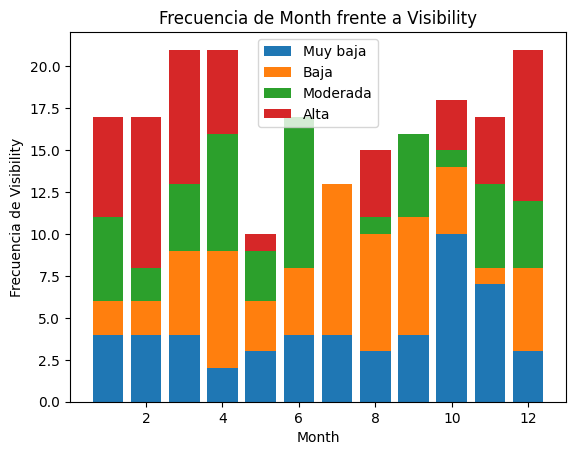

In [69]:
frecuenciaDosVar(data_clase, 'Month', variables[2])

Tal como se había visto previamente, la visibilidad es mayor en los meses de invierno, mientras que es peor en verano. En relación con su grupo, este también está compuesto por la variable Inversion_base_height, esta variable muestra la contaminación causada por la capa de inversión térmica, un fenómeno que puede atrapar contaminantes cerca de la superficie. De esta manera, es lógico pensar que cuantos más contaminantes haya, peor será la visibilidad.

Además, como se había analizado en la matriz de correlación, los grupos uno y dos estaban inversamente relacionados entre sí. Observando ambas gráficas, confirmamos cómo los meses de aumento de uno y otro son opuestos. Sin embargo, esta nueva gráfica nos proporciona información adicional. En este caso, la alta visibilidad se extiende desde diciembre hasta abril, y una mala visibilidad desde mayo hasta septiembre. Estas conclusiones no se podrían haber obtenido simplemente invirtiendo la gráfica anterior, por lo que hemos obtenido información valiosa adicional.

Análisis sobre el grupo 3: Pressure_gradient

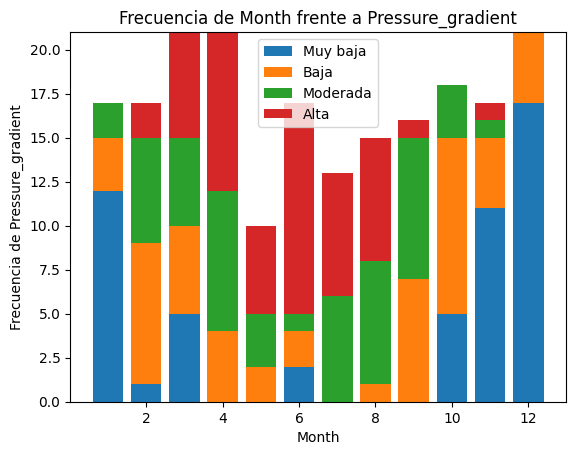

In [70]:
frecuenciaDosVar(data_clase, 'Month', variables[1])

Se puede apreciar que pressure_gradient se ve afectado por el mes de medicion. Entre septiembre y febrero los valores de la presion son mas bajos, sobre todo en Diciembre y enero. Mientras que desde marzo hasta agosto, sobre todo en mayo y junio los valores son mucho mas altos.

El pressure_gradient mide el cambio de la presión debido a diversos factores como el viento o la humedad, es por este motivo que está relacionado con Wind_speed y Humidity. Estas variables nos ayudan a entender de manera lógica los resultados. La humedad aumenta con las altas lluvias propias de la primavera y principios de verano, mientras que los meses con mayores vientos suelen ser a finales de invierno y principios de primavera. Gracias a esto, se le da una estructura lógica a los resultados.

### **Distribución de cada variable**


### QQ plot

El Q-Q (cuantil-cuantil) plot es una herramienta gráfica que se utiliza para **comparar la distribución de un conjunto de datos con una distribución teórica**, permitiendo visualizar si ambos conjuntos de datos provienen de la misma distribución. Para ello, se trazan los cuantiles de los datos contra los cuantiles esperados de la distribución teórica. Si los datos siguen la distribución teórica, los puntos en el gráfico se **alinearán** aproximadamente a lo largo de una línea recta.

Para poder realizar lo explicado, se crea la función `qqplot(data_var, distribucion)`, la cual compara la distribución del conjunto de datos (`data_var`) con una distribución teórica (`distribucion`). En este caso, la distribución teórica que se utilizará es la **distribución normal** (`'norm'`), aunque se podría cambiar el argumento `distribucion`. Cuanto más cerca estén los puntos de esta línea, más probable es que los datos sigan una distribución normal.

Por lo tanto, **se evalúa primero a través de un histograma con una distribución normal ajustada superpuesta**, y luego, usando un **Q-Q plot** para una comparación más detallada con la distribución normal teórica.

### **Distribución de Pressure gradient**

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def qqplot(data_var,distribucion):
  # Generar el QQ-plot
  stats.probplot(data_var, dist=distribucion, plot=plt)

  # Añadir título y mostrar el gráfico
  plt.title('Q-Q Plot')
  plt.show()

def ajustarNormal(data_var,var):
  # Ajustar una distribución normal a los datos
  mu, std = stats.norm.fit(data_var)

  # Generar puntos en el eje x desde el mínimo hasta el máximo de tus datos
  x = np.linspace(min(data_var), max(data_var), 100)

  # Calcular la PDF (Función de Densidad de Probabilidad) de la distribución normal ajustada
  p = stats.norm.pdf(x, mu, std)

  # Graficar el histograma de tus datos
  plt.hist(data_var, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

  # Graficar la distribución normal ajustada
  plt.plot(x, p, 'k', linewidth=2, label='Fitted Normal Distribution')

  # Añadir título y leyenda
  plt.title(f"Distirbución de {var}")
  plt.xlabel("Data")
  plt.ylabel("Density")
  plt.legend()

  # Mostrar la gráfica
  plt.show()

  qqplot(data_var,'norm')

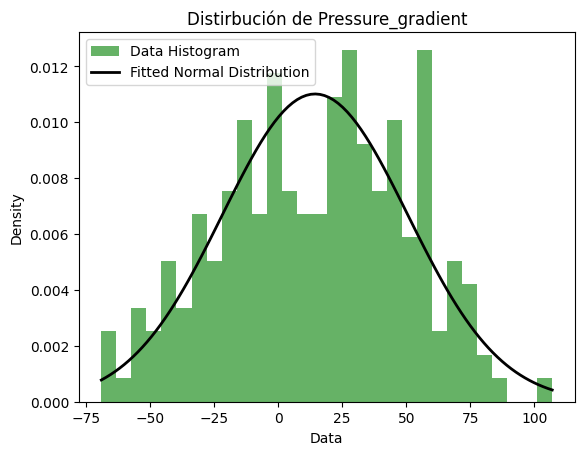

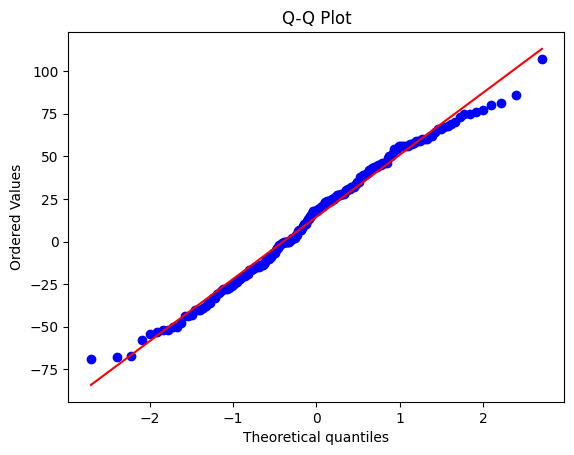

In [72]:
ajustarNormal(df['Pressure_gradient'],'Pressure_gradient')

### **Conclusion gráfica**
1. **Histograma con Distribución Normal Ajustada:**
- La primera gráfica es un histograma que muestra la frecuencia de los datos de la variable `Pressure_gradient` con barras verdes y una distribución normal ajustada representada por la curva negra. Lo que se observa aquí es que la distribución de los datos no es perfecta. Los datos muestran cierta asimetría, ya que hay una cola más larga hacia la derecha. Además, la curva negra (la distribución normal ajustada) no captura algunos de los picos del histograma, especialmente en el centro y en la cola derecha del gráfico.

2. **Q-Q Plot:**
- La segunda gráfica es un Q-Q plot que compara los cuantiles de los datos de `Pressure_gradient` con los cuantiles que se esperarían si los datos siguieran una distribución normal. La línea recta roja representa lo que se esperaría si los datos fueran normalmente distribuidos. Los puntos azules representan los datos reales. Si los puntos azules caen sobre la línea roja, eso indica que los datos se distribuyen normalmente. En este gráfico, la mayoría de los puntos siguen la línea recta, pero desviaciones notables en los extremos (especialmente en el extremo superior derecho) indican que los datos tienen colas más pesadas que una distribución normal, lo cual es consistente con la asimetría observada en el histograma.

3. **Beneficios de que se distribuyan de forma normal:**
- La distribución normal ofrece beneficios significativos en el análisis de la presión del gradiente debido a su facilidad de interpretación y la simplificación de cálculos asociados con estadísticas descriptivas y modelos estadísticos. La robustez de la distribución normal frente a desviaciones moderadas amplía su utilidad al proporcionar resultados confiables incluso en casos donde los datos no se ajustan perfectamente a la distribución. Esta característica facilita el uso de métodos estadísticos, como la regresión lineal y el análisis de varianza, que asumen normalidad en los datos

### **Distribución ozone reading**

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def ajustarLogNormal(data_var, var):
    # Ajustar una distribución lognormal a los datos
    shape, loc, scale = stats.lognorm.fit(data_var, floc=0)

    # Generar puntos en el eje x desde el mínimo hasta el máximo de tus datos
    x = np.linspace(min(data_var), max(data_var), 100)

    # Calcular la PDF (Función de Densidad de Probabilidad) de la distribución lognormal ajustada
    p = stats.lognorm.pdf(x, shape, loc=0, scale=scale)

    # Graficar el histograma de tus datos
    plt.hist(data_var, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

    # Graficar la distribución lognormal ajustada
    plt.plot(x, p, 'k', linewidth=2, label='Fitted Lognormal Distribution')

    # Añadir título y leyenda
    plt.title(f"Distribución de {var} (lognormal)")
    plt.xlabel("Datos")
    plt.ylabel("Densidad")
    plt.legend()

    # Mostrar la gráfica
    plt.show()

In [74]:
def qqplotLog(data_var):
  # Transformar los datos a una escala logarítmica
  log_data_var = np.log(data_var)

  # Generar el QQ-plot utilizando la función 'probplot' comparando con una distribución normal
  # debido a que los datos han sido transformados logarítmicamente
  stats.probplot(log_data_var, dist="norm", plot=plt)

  # Añadir título y mostrar el gráfico
  plt.title('Log-Normal QQ Plot')
  plt.xlabel('Cuantiles Teoricos')
  plt.ylabel('Valores (log scale)')
  plt.show()

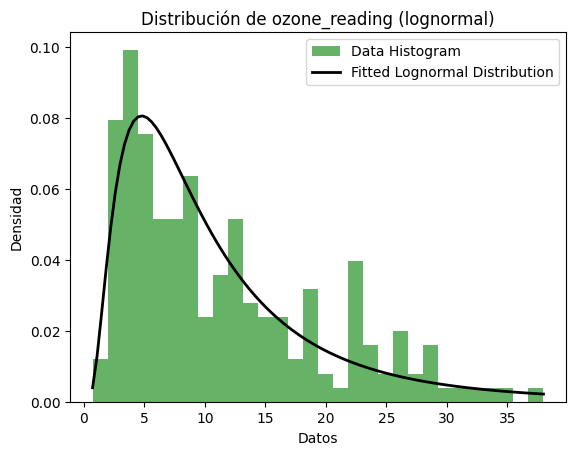

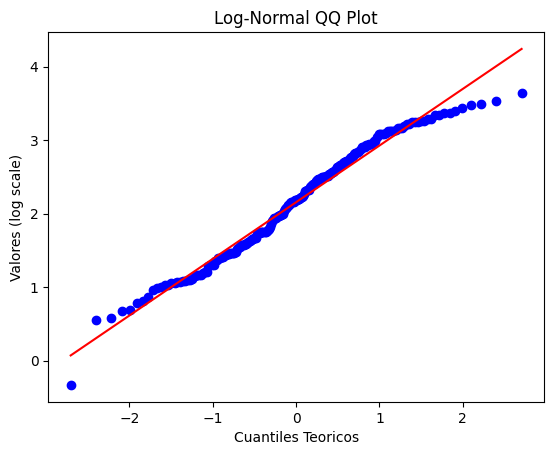

In [75]:
ajustarLogNormal(df['ozone_reading'], 'ozone_reading')
qqplotLog(df['ozone_reading'])

### **Conclusion gráfica**
1. **Histograma con Distribución Log Normal Ajustada y Q-Q plot:**
- La primera gráfica muestra un histograma de la variable `ozone_reading`, con barras verdes representando la frecuencia de los datos y una distribución normal ajustada mediante una curva negra. En la segunda gráfica, se observa cómo los datos de `ozone_reading` se aproximan teóricamente a una distribución log-normal, aunque con cierto error en los extremos. Esto indica que la distribución de los datos no es perfecta, pero en su mayoría coincide con la distribución log-normal. También cabe mencionar que otras posibles distribuciones como Beta, Alpha, Chi-Cuadrado y exponencial podrían aproximarse, aunque al comparar gráficamente con el qqplot, se observa que la distribución log-normal presenta menos discrepancias y errores.

2. **Beneficios de que se distribuyan de forma log normal:**
- Primero, indica que los valores extremos son relativamente comunes y que la distribución de los datos está sesgada hacia valores más altos. Esta información es crucial para comprender la variabilidad en los niveles de ozono. Además, la distribución log-normal sugiere que los cambios relativos en los niveles de ozono son más importantes que los cambios absolutos, lo que puede influir en la implementación de políticas y medidas de control de la contaminación más efectivas y enfocadas en áreas donde los niveles de ozono son más altos.

### **Distribución de Visibilidad**

Analizamos ahora la distribución seguida por Visibility. Esta variable es diferente de las previamente analizadas debido a la naturaleza discreta que posee. Por este motivo se ha realizado el análisis sobre una poisson.

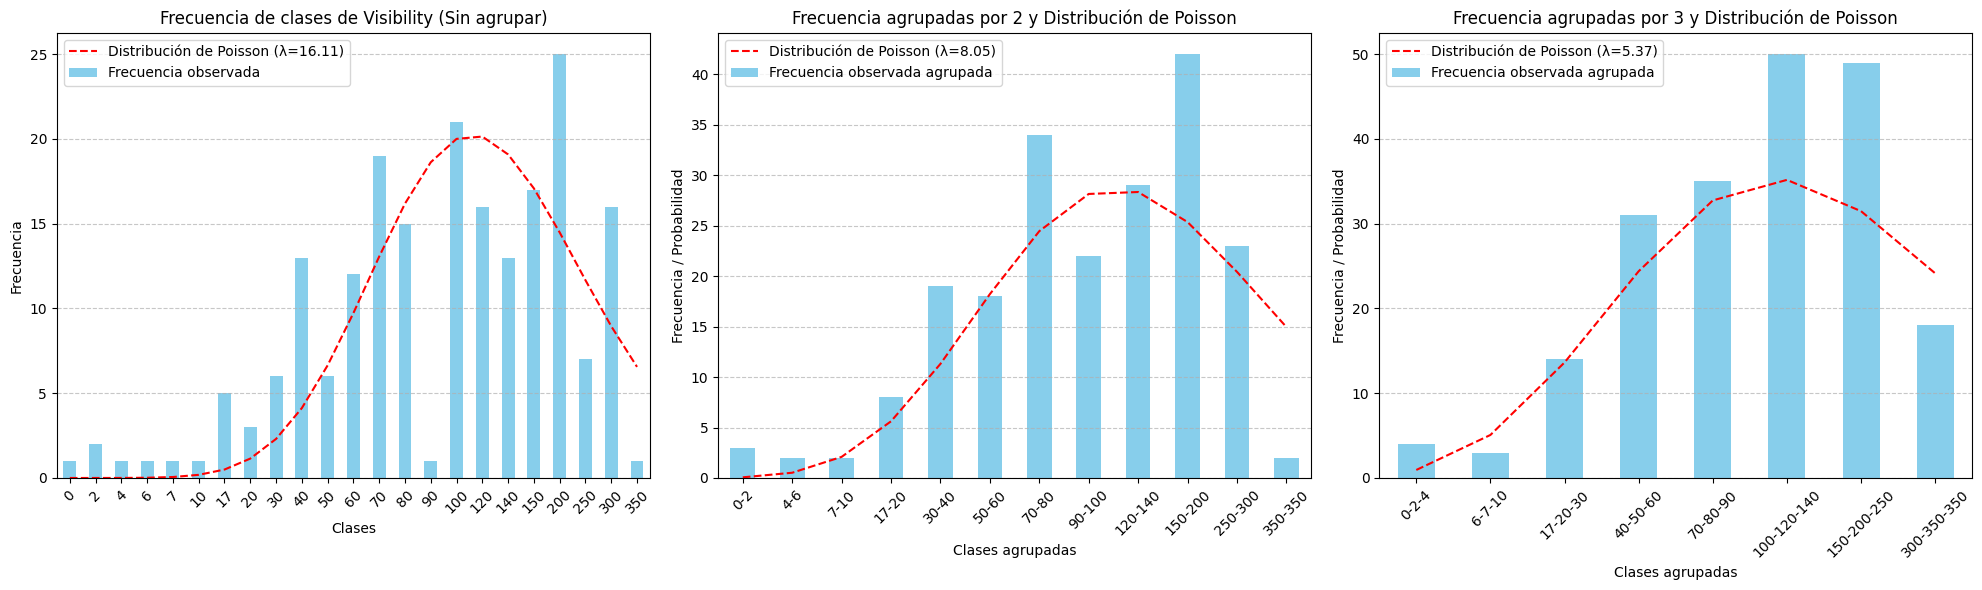

In [76]:
from scipy.stats import poisson

def plot_variable_distribution(df_visibility):
    # Calcular la frecuencia de cada clase
    visibility_counts = df_visibility.value_counts()
    visibility_counts_sorted = visibility_counts.sort_index()

    # Configurar el subplot
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Configurar los parámetros para cada tipo de agrupación
    groupings = [(1, None), (2, 2), (3, 3)]

    for i, (subplot_index, grouping_size) in enumerate(groupings):
        ax = axs[i]

        if grouping_size:
            # Agrupar las clases
            unique_categories = visibility_counts_sorted.index
            if len(unique_categories) % grouping_size != 0:
                unique_categories = np.append(unique_categories, [unique_categories[-1]] * (grouping_size - (len(unique_categories) % grouping_size)))

            grouped_visibility_counts = {}
            for j in range(0, len(unique_categories), grouping_size):
                group_key = '-'.join(map(str, unique_categories[j:j + grouping_size]))
                grouped_visibility_counts[group_key] = visibility_counts_sorted.loc[unique_categories[j:j + grouping_size]].sum()

            grouped_visibility_counts_series = pd.Series(grouped_visibility_counts)
            grouped_visibility_counts_series.plot(kind='bar', color='skyblue', label='Frecuencia observada agrupada', ax=ax)

            # Calcular la distribución de Poisson
            mu = ((df_visibility.mean() - 120) / 20 + 16) / grouping_size
            x = np.arange(0, len(grouped_visibility_counts_series))
            poisson_pmf = poisson.pmf(x, mu)
            ax.plot(x, poisson_pmf * len(df_visibility), 'r--', label=f'Distribución de Poisson (λ={round(mu, 2)})')

            ax.set_title(f'Frecuencia agrupadas por {grouping_size} y Distribución de Poisson')
            ax.set_xlabel('Clases agrupadas')
            ax.set_ylabel('Frecuencia / Probabilidad')
            ax.set_xticks(range(len(grouped_visibility_counts_series)))
            ax.set_xticklabels(grouped_visibility_counts_series.index, rotation=45)
        else:
            # Sin agrupación, mostrar clases individuales
            visibility_counts_sorted.plot(kind='bar', color='skyblue', label='Frecuencia observada', ax=ax)
            ax.set_title('Frecuencia de clases de Visibility (Sin agrupar)')
            ax.set_xlabel('Clases')
            ax.set_ylabel('Frecuencia')
            ax.set_xticks(range(len(visibility_counts_sorted)))
            ax.set_xticklabels(visibility_counts_sorted.index, rotation=45)

            # Calcular la distribución de Poisson
            mu = (df_visibility.mean() - 120) / 20 + 16
            x = np.arange(0, len(visibility_counts_sorted))
            poisson_pmf = poisson.pmf(x, mu)
            ax.plot(x, poisson_pmf * len(df_visibility), 'r--', label=f'Distribución de Poisson (λ={round(mu, 2)})')

        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# Suponiendo que df es tu DataFrame y 'Visibility' es la columna que contiene las categorías
# Llamamos a la función pasando df['Visibility'] como argumento
plot_variable_distribution(df['Visibility'])

1. Histograma con Distribución Poisson

- Cada gráfico de barras representa una categoría. En la primera gráfica, se toman las categorías de forma natural, mientras que para las dos siguientes se agrupan para añadir confirmación al ajuste. La distribución de Poisson está realizada sobre la media de Visibility, la cual está cerca de 122. De este modo, la media para la distribución de Poisson será un poco superior a la clase en la que se encuentre el 120 en cada caso.

  De esta manera, se tiene que la visibilidad parece tener una estructura similar a una distribución de Poisson, con valores más repetidos cerca de la media y descendiendo gradualmente al alejarse. Sin embargo, los datos no siguen perfectamente esta distribución aunque si de forma aproximada, ya que como se puede ver en la clase 90, que es inferior, o en la 200, que es superior, pero los valores son similares a la media.

2. Beneficios de que se distribuyan como una Poisson
-
La distribución de Poisson es particularmente adecuada para modelar eventos independientes debido a su propiedad de contar el número de eventos que ocurren en un intervalo de tiempo o espacio específico. Esta distribución supone que la ocurrencia de un evento no afecta la ocurrencia de otro evento en el mismo intervalo, lo que es común en situaciones donde los eventos son raros y no están correlacionados entre sí, como hemos observado en el primer y segundo apartado esta variables tiene una gran catnidad de outlaiers lo que sería coherente si entendemso que lso eventos son independientes.




#**Ejercicio 3**
Existen casos en que las variables no se pueden representar visualmente debido a que necesitaríamos varias dimensiones para ello. Para evitar esto, existe una metodología en la cual, un set de datos multidimensional, podemos transformarlo para poder explicar gran parte de la información en 2 o 3 dimensiones. Dicha
metodología se conoce con el nombre de Principal Component Analysis (PCA). Vamos a aplicarlo a un set de datos que está colgado en Canvas llamado USA.xlsx y vamos a dar una serie de explicaciones de que ocurre.
* En primer lugar, se procederá a una estandarización de los datos dado para evitar problemas de rango a la hora de procesar la información.
* Tras ello se emplearán los métodos de Numpy para calcular los autovalores y autovectores de la matriz de covarianza para seleccionar el número óptimo de componentes principales.
* Tras obtener las componentes principales se representaran de manera gráfica las ciudades para su posterior análisis.
* Ultimamente se realizaran los procesos anteriores de nuevo, pero empleando la librería scikit-learn y centrandose en recalcar las diferencias entre los métodos y las similitudes.

***Bibliotecas y Carga de Datos***

En el siguiente bloque de código se importan las librerías necesarias para realizar el ejercicio.

In [77]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.covariance import EmpiricalCovariance
import matplotlib.colors as mcolors


A continuación, se cargan los datos desde un archivo Excel en un DataFrame de pandas y se proporciona un resumen informativo de la estructura y el contenido de este DataFrame.

In [78]:
uploaded = files.upload()

# Carga de datos desde un archivo Excel y visualización de las primeras 10 filas
df = pd.read_excel('USA.xlsx')

# Para mostrar información general sobre el DataFrame, incluyendo el número de valores no nulos y el tipo de datos de cada columna:
print(df.info())

print(df.head(10))

Saving USA.xlsx to USA.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ciudad     41 non-null     object 
 1   SO2        41 non-null     float64
 2   Neg.Temp   41 non-null     float64
 3   Empresas   41 non-null     float64
 4   Poblacion  41 non-null     float64
 5   Viento     41 non-null     float64
 6   Precip     41 non-null     float64
 7   Dias       41 non-null     float64
dtypes: float64(7), object(1)
memory usage: 2.7+ KB
None
          Ciudad   SO2  Neg.Temp  Empresas  Poblacion  Viento  Precip   Dias
0        Phoenix  10.0      70.3     213.0      582.0     6.0    7.05   36.0
1    Little Rock  13.0      61.0      91.0      132.0     8.2   48.52  100.0
2  San Francisco  12.0      56.7     453.0      716.0     8.7   20.66   67.0
3         Denver  17.0      51.9     454.0      515.0     9.0   12.95   86.0
4       Hartford  56.0      

Se puede comprobar que cada una de las columnas numéricas **SO2, Neg.Temp, Empresas, Poblacion, Viento, Precip, Dias** tiene 41 valores no nulos, lo que indica que no hay valores faltantes en estas columnas y que cada columna tiene 41 filas de datos.

Las columnas **SO2, Neg.Tem, Empresas, Poblacion, Viento, Precip y Dias** son de tipo float64, lo que significa que contienen números reales.

La columna **Ciudad** es de tipo object, lo cual nos confirma que contiene datos de tipo string.

Explicación del significado de algunas de las variables:

**SO2 (Contenido en SO2):** Niveles de dióxido de azufre en el aire, un indicador común de contaminación ambiental.

**Neg.Temp (Temperatura anual en grados F):** Promedio de la temperatura ambiental medida a lo largo del año en grados Fahrenheit.

**Empresas (número de empresas mayores de 20 trabajadores):** Indicador de la actividad económica en una región.

**Población (en miles de habitantes):** Tamaño de la población de una ciudad o región, expresado en miles de habitantes.

**Viento:** Velocidad media del viento.

**Precip:** Precipitación anual media, Cantidad promedio de lluvia que cae en un año, importante por ejemplo para la agricultura, la planificación urbana y los estudios del clima.

**Días:** Número de días lluviosos al año.

##**1.- Selección de Características Numéricas y Estandarización.**

El siguiente código selecciona las características numéricas del DataFrame y las estandariza para que las diferencias de rango
no supongan un problema a la hora de procesar la información.



La estandarización se realiza mediante la sustracción del promedio de cada característica y la división del resultado por la desviación estándar.

Para una característica X, cada elemento xi de esa característica se transforma en xi' mediante la siguiente fórmula:

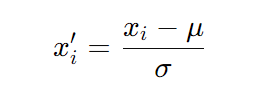


Donde:

xi es el valor original de la característica.

μ es la media de la característica.

σ es la desviación estándar de la característica.

In [79]:
# Se seleccionan solo las columnas con datos numéricos float64) del DataFrame
numeric_features = df.select_dtypes(include=['float64'])

# Se inicializa el objeto StandardScaler para normalizar las características numéricas
scaler = StandardScaler()

# Se ajusta el escalador a las características numéricas y transformarlas
scaled_numeric_features = scaler.fit_transform(numeric_features)

# Creamos un nuevo DataFrame con las características numéricas escaladas
df_scaled_numeric = pd.DataFrame(scaled_numeric_features, columns=numeric_features.columns, index=numeric_features.index)

print(df_scaled_numeric.head(10))

        SO2  Neg.Temp  Empresas  Poblacion    Viento    Precip      Dias
0 -0.864758  2.036213 -0.449363  -0.046520 -2.440555 -2.556012 -2.975514
1 -0.735360  0.733515 -0.668567  -0.833224 -0.881504  1.010653 -0.531009
2 -0.778493  0.131192 -0.018143   0.187743 -0.527174 -1.385471 -1.791457
3 -0.562829 -0.541168 -0.016346  -0.163651 -0.314576 -2.048577 -1.065744
4  1.119347 -0.933378 -0.091810  -0.787770 -0.314576  0.567723  0.500266
5  0.256692 -0.247010 -0.688331  -0.924132 -0.314576  0.299384  0.003726
6 -0.045237  0.215237 -0.052281   0.259420 -0.101978  0.182416 -0.110860
7 -0.692227  1.770071 -0.587713  -0.139176 -0.456308  1.522388  0.080117
8 -0.864758  2.764604 -0.460144  -0.478333 -0.314576  1.980800  0.538462
9 -0.260900  0.803553 -0.170867  -0.195120 -0.243710  0.995172  0.041922


##**2.- Cálculo de la matriz de Covarianza, obtención de los autovalores y autovectores, DataFrame con el porcentaje de varianza y el acumulado por cada componente.**

***Cálculo de la Matriz de Covarianza y Descomposición en Valores Propios***

Antes de continuar con el código se explicará de manera breve que es la matriz de covarianza:

La **matriz de covarianza** es una herramienta estadística que captura la covarianza entre pares de variables en un conjunto de datos. Esta matriz sirve para entender cómo varían conjuntamente las variables en un espacio de datos multidimensional.

Interpretación de los Valores
- **Valores Positivos:** Indican que las variables tienden a moverse en el mismo sentido.
- **Valores Negativos:** Sugieren que las variables se mueven en sentidos opuestos.
- **Valores Cercanos a Cero:** Indican una falta de relación lineal fuerte entre las variables.

En PCA se utiliza para identificar los sentidos principales de variación en los datos, permitiendo una reducción de dimensionalidad efectiva.


A partir de los datos previamente estandarizados, se calcula la matriz de covarianza mediante el método **.cov** y después se aplica a dicha matriz el método **linalg.eig** para obtener los autovectores y autovalores.

Se destaca a continuación el **método para obtener los autovectores de una matriz A de manera analítica** ya que es muy útil para entender la teoría detrás de los autovalores y autovectores.


**PASO 1: Encontrar los Autovalores (λ):**

Se calcula el determinante de la matriz A−λI, donde A es la matriz de interés e I es la matriz identidad de la misma dimensión que A.

Se iguala el determinante a cero y se resuelve para λ, lo que nos da la ecuación característica de la matriz.

Los valores de λ que satisfacen la ecuación son los autovalores de A.

**PASO 2: Encontrar los Autovectores (v):**

Para cada autovalor λ encontrado, se resuelve el sistema de ecuaciones lineales (A-λI)v=0.

Este sistema puede ser resuelto usando eliminación gaussiana, descomposición LU, o cualquier otro método aplicable para sistemas lineales.

Las soluciones no triviales (diferentes de cero) para v son los autovectores asociados con el autovalor λ.

**PASO 3: Construir el Espacio Propio (Eigenspace):**

Los autovectores correspondientes a un autovalor particular forman un espacio vectorial llamado el eigenspace.
Este espacio puede contener uno o más vectores, dependiendo de la multiplicidad del autovalor


**FUNCIÓN PARA GRAFICAR LAS MATRICES DE COVARIANZA**

In [80]:
def plot_covariance_matrix(cov_matrix, variables, title='Matriz de Covarianza'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Definimos el mapa de colores
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "white", "blue"])

    # Crear el heatmap
    cax = ax.matshow(cov_matrix, interpolation='nearest', cmap=cmap, vmin=-1, vmax=1)

    # Añadimos la barra de colores
    fig.colorbar(cax)

    # Establecer los nombres de las variables en los ejes
    ax.set_xticks(np.arange(len(variables)))
    ax.set_yticks(np.arange(len(variables)))
    ax.set_xticklabels(variables)
    ax.set_yticklabels(variables)

    # Rotar los nombres de las variables en el eje x para mejor visualización
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor", verticalalignment='top')


    # Añadir anotaciones de texto
    for (i, j), val in np.ndenumerate(cov_matrix):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

    ax.set_title(title)
    plt.show()

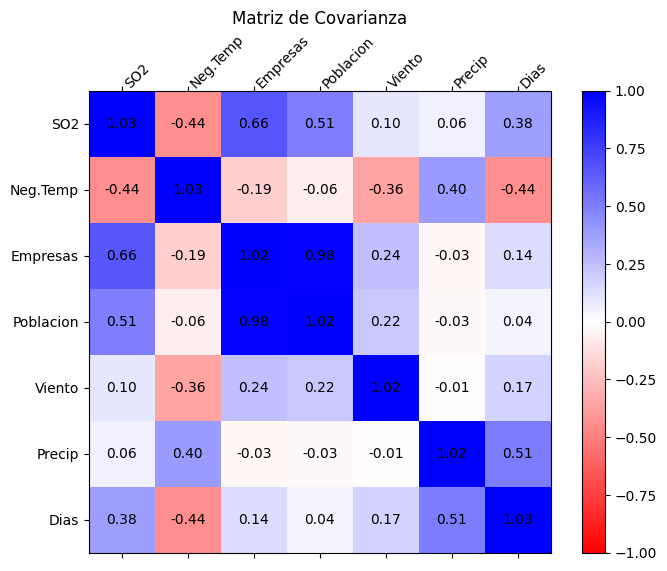

In [81]:
variables = ['SO2', 'Neg.Temp', 'Empresas', 'Poblacion', 'Viento', 'Precip', 'Dias']
# Calcul la matriz de covarianza para df_scaled_numeric, necesaria para PCA
cov_matrix = np.cov(scaled_numeric_features.T)
#Transponemos porque np.cov espera que cada variable
# esté representada por una fila en la matriz de entrada, no por una columna.

# Eigenvalores y eigenvectores derivados de la matriz de covarianza
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Creación de DataFrame a partir de la matriz de covarianza para una manipulación más fácil
df_cov = pd.DataFrame(cov_matrix, columns=numeric_features.columns, index=numeric_features.columns)

plot_covariance_matrix(df_cov,variables)


El **color** de cada celda de la matriz representa la magnitud y la dirección de la covarianza entre cada par de variables: los **tonos azules** indican una **covarianza positiva** (relación directa), mientras que los **tonos rojos** indican una **covarianza negativa** (relación inversa). Cuanto más intenso es el color, más fuerte es la relación.

Se puede ver que hay una covarianza positiva fuerte entre **"Empresas" y "Poblacion"** (0.98), lo que confirma que estas dos variables tienden a aumentar juntas.

También, por ejemplo, **"Viento" y "Precip"** tienen una covarianza muy cercana a 0 lo que indica que la velocidad media del viento no está relacionada con la precipitación anual media.

**VALORES LIGERALMENTE SUPERIORES A 1 EN LA DIAGONAL**

En la matriz de covarianza de datos estandarizados, los valores en la diagonal representan la varianza de las variables individuales.

Como los datos se han estandarizado con el objeto StandardScaler para tener una media de 0 y una desviación estándar de 1, entonces la varianza (que es el cuadrado de la desviación estándar) también debería ser 1. Sin embargo, hay varias **razones** que consideramos que pueden afectar a que existan **valores ligeramente superiores a 1**, como 1.02 o 1.03, en la **diagonal** de la matriz de covarianza:

La **estimación de la varianza** de una muestra puede ser **ligeramente sesgada**. Además, las operaciones matemáticas pueden acumular **errores de redondeo**, lo que puede llevar a que la varianza estimada sea ligeramente superior a 1.

Destacar además que **numpy.cov()** **no** ofrece funcionalidades como la **detección de valores atípicos** o la **regularización de la matriz de covarianza**.

***Ordenación de los Valores Propios y Cálculo de Varianza Explicada***.



**Los autovectores** indican las direcciones en el espacio multidimensional de los datos donde éstos muestran la mayor variabilidad. Cada autovector señala hacia un eje de un nuevo espacio de características, **conocido como componente principal**, donde los datos están más dispersos.

**Los autovalores**, por otro lado, cuantifican la cantidad de varianza que cada autovector captura. Un autovalor alto significa que su autovector correspondiente apunta hacia una dirección en la que los datos tienen una gran dispersión. Los autovalores ofrecen una **medida de la importancia relativa de cada componente principal** en la explicación de la variabilidad observada en el conjunto de datos original.

Al ordenar los autovalores de **mayor a menor**, podemos priorizar los autovectores asociados en términos de su capacidad para capturar la información esencial de los datos. Esta organización nos permite identificar que **componentes principales retienen la mayor parte de la información útil**, lo que es esencial para la reducción de la dimensionalidad: seleccionamos los primeros autovectores (componentes principales) que corresponden a los autovalores más grandes, y estos se utilizan para transformar el conjunto de datos original a un espacio con menos dimensiones, minimizando la pérdida de información.

In [82]:
# Calculamos los índices para ordenar los eigenvalores de mayor a menor
indice_ordenado = np.argsort(eigenvalues)[::-1]

# Ordenamos los eigenvalores y eigenvectores según los índices obtenidos
valores_propios_ordenados = eigenvalues[indice_ordenado]
vectores_propios_ordenados = eigenvectors[:, indice_ordenado]

# Varianza explicada por cada componente principal y la varianza acumulada explicada
varianza_explicada = [(i / sum(valores_propios_ordenados))*100 for i in valores_propios_ordenados]
varianza_acumulada_explicada = np.cumsum(varianza_explicada)

# DataFrame con la información de varianza explicada, acumulada y los valores propios para cada componente principal
df_varianza = pd.DataFrame({'Componente': range(1, len(varianza_explicada) + 1),
                            'Valor Propio': valores_propios_ordenados,  # Añadimos la columna de valores propios
                            'Varianza (%)': varianza_explicada,
                            'Varianza acumulada (%)': varianza_acumulada_explicada})


# Imprimir el DataFrame sin índices para una mejor visualización
print(df_varianza.to_string(index=False))




 Componente  Valor Propio  Varianza (%)  Varianza acumulada (%)
          1      2.796323     38.973138               38.973138
          2      1.550143     21.604784               60.577922
          3      1.429847     19.928186               80.506108
          4      0.914291     12.742733               93.248840
          5      0.355448      4.953981               98.202821
          6      0.102795      1.432680               99.635501
          7      0.026153      0.364499              100.000000


**Componente**: Indica el número de componente principal, desde el primero hasta el séptimo en este caso.

**Varianza** **(%)**: Representa el porcentaje de la varianza total de los datos que cada componente principal capta o explica. Cuanto mayor sea el porcentaje, más variabilidad de los datos originales se captura en esa componente.

**Varianza acumulada (%):** Muestra el porcentaje acumulado de varianza explicada por todos los componentes hasta ese punto. Por ejemplo, el primer componente explica el 38.973% de la varianza, y el segundo componente lleva la varianza acumulada al 60.577%, que es la suma del primero y segundo componente.

**Valor Propio:** O autovalor, este número indica la magnitud del componente principal. Un valor propio mayor indica un componente que captura más varianza.

**GRÁFICO VARIANZA ACUMULADA**

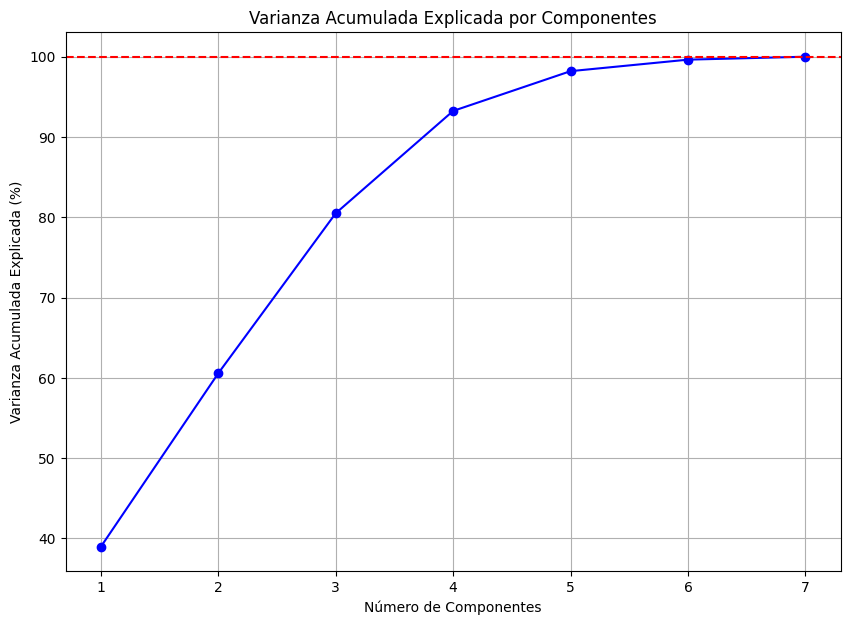

In [83]:
plt.figure(figsize=(10, 7))

# Para graficar la varianza acumulada explicada
componentes = range(1, len(varianza_acumulada_explicada) + 1)
plt.plot(componentes, varianza_acumulada_explicada, marker='o', linestyle='-', color='blue')

# Títulos y etiquetas a los ejes
plt.title('Varianza Acumulada Explicada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada (%)')

# Rejilla para mejor lectura
plt.grid(True)

# Línea horizontal al 100% de varianza explicada
plt.axhline(100, color='red', linestyle='--')

plt.show()

Este gráfico es una representación visual de los datos de la tabla que previamente se ha mostrado.

**En el eje horizontal (X)** se enumeran los componentes, del 1 al 7.

**En el eje vertical (Y)** se muestra el porcentaje de la varianza acumulada explicada por los componentes.

Cada **punto** en el gráfico representa la **varianza acumulada explicada por los componentes hasta ese número**. Por ejemplo, el primer punto muestra la varianza explicada por el primer componente, el segundo punto la varianza explicada por los dos primeros componentes juntos, y así sucesivamente.

**La línea azul sube rápidamente al principio,** lo que indica que los primeros componentes explican una gran parte de la información de los datos. A medida que se agregan más componentes, la línea se aplana, lo que indica que cada componente adicional explica una parte cada vez menor de la varianza.

**La línea discontinua roja** en la parte superior del gráfico representa el 100% de la información de los datos, que es el total de la información que podrían explicar todos los componentes si se incluyeran.

**FUNCIÓN PARA GRAFICAR LOS AUTOVECTORES.**

In [84]:
def print_styled_eigenvectors(eigenvectors, column_names):
    """
    Imprime un DataFrame de autovectores con estilos aplicados para mejorar la visualización.

    :param eigenvectors: Numpy array de autovectores.
    :param column_names: Lista de nombres de columnas para usar como índices en el DataFrame de autovectores.
    """
    autovectores_df = pd.DataFrame(eigenvectors,
                                   columns=[f"Autovector {i+1}" for i in range(eigenvectors.shape[1])],
                                   index=column_names)

    # Aplicamos estilos para mejorar la visualización del DataFrame
    styled_df = autovectores_df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '10pt'), ('min-width', '100px')]}]
    ).background_gradient(cmap='coolwarm_r').format("{:.2f}")

    return styled_df

Se muestra a continuación un Dataframe de los autovectores obtenidos.

In [85]:
styled_df = print_styled_eigenvectors(vectores_propios_ordenados, df_scaled_numeric.columns)
display(styled_df)


,Autovector 1,Autovector 2,Autovector 3,Autovector 4,Autovector 5,Autovector 6,Autovector 7
SO2,0.49,0.08,-0.01,-0.40,-0.73,0.18,-0.15
Neg.Temp,-0.32,-0.09,-0.68,0.19,-0.16,0.61,0.02
Empresas,0.54,-0.23,-0.27,0.03,0.16,-0.04,0.75
Poblacion,0.49,-0.28,-0.34,0.11,0.35,-0.09,-0.65
Viento,0.25,0.06,0.31,0.86,-0.27,0.15,-0.02
Precip,0.00,0.63,-0.49,0.18,-0.16,-0.55,0.01
Dias,0.26,0.68,0.11,-0.11,0.44,0.50,-0.01


El **DataFrame** muestra una representación visual de los autovectores (eigenvectors) obtenidos. Los autovectores, cuando se les aplica una transformación lineal (como la matriz de covarianza), no cambian su dirección y solo se escalan por un factor, el autovalor (eigenvalue) asociado.

Cada **columna** en la imagen **representa un autovector diferente**, identificado como "Autovector 1" hasta "Autovector 7". Cada fila representa una de las variables originales en el conjunto de datos (SO2, Neg.Temp, Empresas, Poblacion, Viento, Precip, Dias). Los valores en las celdas indican la magnitud y la dirección de cada variable en el autovector correspondiente. Estos valores son los coeficientes que forman los autovectores y pueden interpretarse como la contribución de cada variable original a la componente principal correspondiente.

Los colores en las celdas indican si la contribución es positiva (azul) o negativa (rojo), y la **intensidad del color refleja la magnitud de esa contribución**. Un valor cercano a 1 o -1 significa que la variable tiene una fuerte influencia en esa componente principal, mientras que un valor cercano a 0 significa que tiene poca o ninguna influencia.

Por ejemplo, **"Autovector 4"** muestra una alta contribución de "Viento" (0.86), lo que podría interpretarse como que esta componente principal está fuertemente influenciada por el clima o condiciones meteorológicas.

**¿Cuánta información perdemos con 2 componentes? ¿Cuánta información
representamos con 3 componentes?**

**Con dos componentes principales**, se pierde aproximadamente el **39.4%** de la información total del conjunto de datos. Esto significa que los dos primeros componentes juntos capturan el 60.6% de la información de los datos originales.

Al observar la contribución de las variables individuales a cada componente principal, podemos destacar cuáles son menos representadas. En este caso, al elegir solo dos componentes, podemos ver que hay una representación significativamente menor de la variabilidad asociada con las variables "**Viento**" y "**Neg.Temp**", ya que estas tienen cargas más bajas en los primeros dos autovectores. Esto indica que la información específica que estas variables aportan al conjunto de datos no está siendo capturada en gran medida por los dos primeros componentes.

Al aumentar a **tres componentes principales**, **representamos** aproximadamente el **80.6%** de la información del conjunto de datos, reduciendo la pérdida de información al 19.4%. Con tres componentes, estamos incluyendo una mayor parte de la variabilidad de los datos, lo cual mejora la representación de variables como "Viento" y "Neg.Temp".

Sin embargo, aún hay una pérdida de información relacionada con las variables menos representadas por estos tres componentes principales como "**Viento**" que en la cuarta componente principal tiene una carga mucho mayor.

***Selección de Componentes Principales y Transformación de Datos***
- Se seleccionan los primeros tres vectores propios ordenados para definir los componentes principales. Al elegir los tres primeros, estamos seleccionando los componentes que más información retienen.
- La transformación es realizada mediante un producto punto entre los datos normalizados y los componentes principales. Esto proyecta los datos originales en el nuevo espacio definido por las componentes principales.
- Se crea un nuevo DataFrame con los datos transformados, que ahora están representados en términos de tres componentes principales (CP1, CP2, CP3). Estas columnas son las nuevas variables en el espacio reducido.
- Se concatena la columna ciudad al DataFrame, lo que es obvio para poder mantener la referencia a la ubicación de los datos.

In [86]:
# Componentes principales utilizando los primeros tres vectores propios ordenados
componentes_principales = vectores_propios_ordenados[:, :3]

# Transformamos los datos originales normalizados utilizando los componentes principales
datos_transformados_pca = np.dot(df_scaled_numeric, componentes_principales)

# DataFrame con los datos transformados en PCA, incluyendo los componentes principales y el nombre de la ciudad
df_pca = pd.DataFrame(datos_transformados_pca, columns=['CP1', 'CP2', 'CP3'])
df_pca = pd.concat([df_pca, df[['Ciudad']]], axis=1)

***Visualización en 3D de los Datos Transformados***



**Componente Principal 1 (CP1):** Esta componente tiene una fuerte influencia positiva de las variables "empresas" , "Población" y "SO2" , y una influencia negativa de la "Temperatura anual", lo que quiere decir que a medida que aumenta el valor de la temperatura anual, el valor de CP1 tiende a disminuir. La CP1 está capturando una combinación de actividad económica, densidad demográfica y contaminación junto con una inversión en la temperatura anual. Las ciudades con valores altos en esta componente podrían ser aquellas con mayor actividad económica, poblaciones más densas y por ende mayor contaminación, pero posiblemente con temperaturas más bajas.

**Componente Principal 2 (CP2):** Esta componente es influida positivamente por la "Precipitación anual media" y los "Días lluviosos al año", y negativamente aunque con poca carga por el "Número de empresas mayores de 20 trabajadores" y la "Población". Esto indica que la CP2 captura información relacionada con el clima, especialmente la humedad y la precipitación, en contraste con el tamaño económico y demográfico de las ciudades.

**Componente Principal 3 (CP3):** La influencia más fuerte en esta componente es la negativa de la "Temperatura anual" y también presenta una contribución negativa de la "Precipitación anual media". Las ciudades con valores más altos en esta componente son las mas cálidas y lluviosas y con más viento.

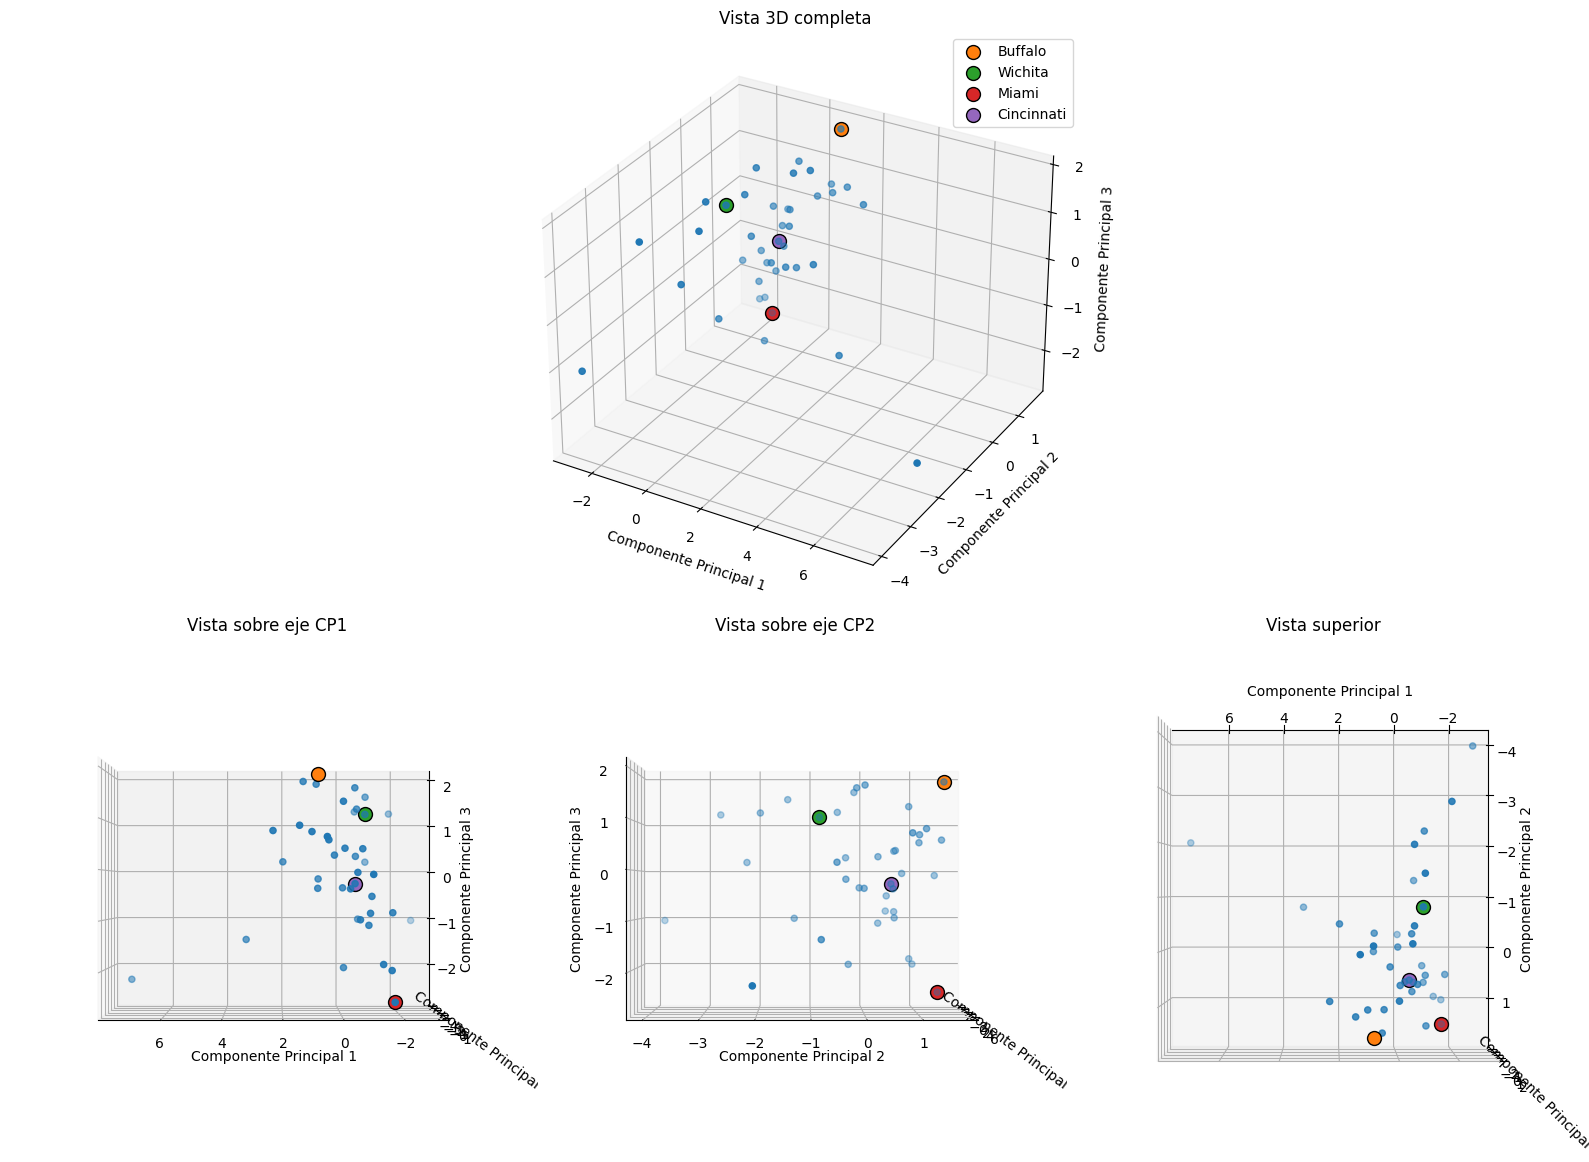

In [87]:

# Configuración de la figura y los ejes
fig = plt.figure(figsize=(16, 12))

# Gráfico completo en la primera fila
ax_full = fig.add_subplot(2, 3, (1, 3), projection='3d')
ax_full.scatter(df_pca['CP1'], df_pca['CP2'], df_pca['CP3'])
ax_full.set_xlabel('Componente Principal 1')
ax_full.set_ylabel('Componente Principal 2')
ax_full.set_zlabel('Componente Principal 3')
ax_full.set_title('Vista 3D completa')

# Subplots para vistas detalladas
axs = [fig.add_subplot(2, 3, i+4, projection='3d') for i in range(3)]

# Configuraciones para cada subplot detallado
views = [(0, 90), (0, 0), (90, 90)]
titles = ['Vista sobre eje CP1', 'Vista sobre eje CP2', 'Vista superior']

for ax, view, title in zip(axs, views, titles):
    ax.scatter(df_pca['CP1'], df_pca['CP2'], df_pca['CP3'])
    ax.view_init(elev=view[0], azim=view[1])
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.set_zlabel('Componente Principal 3')
    ax.set_title(title)

# Semilla aleatoria para reproducibilidad
np.random.seed(42)

# Selección de ciudades aleatorias y visualización en todos los gráficos
random_cities = df_pca['Ciudad'].sample(n=4)
for city in random_cities:
    city_data = df_pca[df_pca['Ciudad'] == city]
    for ax in [ax_full] + axs:
        ax.scatter(city_data['CP1'], city_data['CP2'], city_data['CP3'], s=100, edgecolors='k', label=city)

# Leyenda solo en el gráfico completo
ax_full.legend()

# Mostrar la figura
plt.tight_layout()
plt.show()



**MIAMI**

**Componente Principal 1 (CP1):** Miami muestra valores negativos en la CP1, lo que indica una influencia combinada de un número bajo de empresas y población, y temperaturas anuales muy altas, ya que estas últimas tienen un efecto negativo en la CP1. Esto indica que Miami no se destaca tanto por su actividad económica o densidad demográfica en comparación con otras ciudades del estudio.

**Componente Principal 2 (CP2):** Se observa que Miami tiene valores positivos en la CP2, lo cual se puede interpretar como un reflejo de una mayor cantidad de precipitación anual y un número más alto de días lluviosos. Estas variables influyen positivamente en la CP2, y la posición de Miami en esta componente refuerza su clima característico, que incluye altos niveles de humedad y precipitación.

**Componente Principal 3 (CP3):** Miami también muestra valores negativos en la CP3, lo que indica temperaturas anuales más elevadas. Dado que la "Temperatura anual" tiene una influencia negativa en la CP3, las altas temperaturas de Miami contribuyen a valores más bajos en esta componente, destacando su clima cálido y las grandes precipitaciones en comparación con las otras ciudades analizadas.




**BUFFALO**

**Componente Principal 1 (CP1):** Buffalo muestra valores que se acercan a 1, lo que indica una combinación moderada a alta de actividad económica y densidad de población, ya que estas variables contribuyen positivamente a la CP1. Esto sugiere que Buffalo tiene una economía y población activas, aunque no son las más grandes en comparación con otras ciudades del estudio. Además, como la temperatura no es alta la variable Neg.Temp no afecta negativamente.

**Componente Principal 2 (CP2):** Buffalo presenta valores altos en la CP2, lo que se puede interpretar como una mayor cantidad de precipitación y días lluviosos, ya que "Precip" (precipitación anual) y "Dias" (días lluviosos al año) influyen positivamente en esta componente. Esto está en línea con el conocido clima de Buffalo, que incluye una cantidad significativa de precipitación, especialmente durante los meses de invierno.

**Componente Principal 3 (CP3):** Se observa que Buffalo tiene valores muy altos en la CP3, lo cual indica que la ciudad experimenta temperaturas más bajas en comparación con otras ciudades del análisis. Como la "Temperatura anual" influye negativamente en la CP3, las temperaturas más bajas de Buffalo contribuyen a una puntuación más alta en esta componente, reflejando su clima más frío.

**CINCINNATI**

**Componente Principal 1 (CP1):** Un valor cercano a -1 indica que Cincinnati tiene una cantidad de empresas, pobllación y SO2 no muy alta en comparación con otras ciudades, y al tener valores de temperatura relativamente altas, esto contribuye a su valor negativo en esta componente.

**Componente Principal 2 (CP2):** Un valor más cercano a 1 en esta componente resalta la mayor cantidad de precipitación y días lluviosos en Cincinnati, lo que nos confirma su clima húmedo en comparación con otras ciudades del análisis.

**Componente Principal 3 (CP3):** Un valor ligeramente negativo en la CP3 ajusta la interpretación de las características climáticas de Cincinnati. Dado que la CP3 está influenciada negativamente por la "Temperatura anual", un valor negativo podría indicar que Cincinnati experimenta temperaturas ligeramente más cálidas en comparación con otras ciudades.

**WICHITA**

**Componente Principal 1 (CP1):** Wichita tiene un valor alrededor de -1 en la CP1, lo que tiene sentido viendo  que en Wichita la cantidad de SO2, población y empresas con más de 20 trabajadores es baja en comparación con las demás ciudades. Además, las temperaturas son razonablemente altas, lo que afecta de manera negativa a la CP1.

**Componente Principal 2 (CP2):** Con un valor muy cercano a -1 en la CP2, donde "Precip" y "Dias" tienen la influencia positiva más significativa, Wichita experimenta menos precipitación anual y menos días lluviosos en comparación con otras ciudades.
Además, al tener menos empresas con más de 20 trabajadores y menos población que el promedio de ciudades, resulta en un valor negativo para esta componente principal.

**Componente Principal 3 (CP3)**: Un valor superior a 1 en la CP3 para Wichita consideramos que viene dado porque es la ciudad en la cual la velocidad del viento es más alta.

Se comentarán a continuación diferencias entre distintas ciudades según la vista sobre la que se realice la observación.

**Vista sobre eje CP1 vs CP3** (Buffalo naranja, Wichita verde, Miami rojo, Cincinnati púrpura):

**Buffalo y Cincinnati:** Buffalo tiene un valor positivo en CP1, cercano a 1, mientras que Cincinnati tiene un valor cercano a -1, y como tienen una actividad económica y población similares, esto se debe a las altas temperaturas de Cincinnati.

Además, en CP3, Buffalo tiene un valor mucho más alto, lo que indica temperaturas más bajas en comparación con Cincinnati y más viento. Esto muestra que, aunque ambas ciudades pueden tener una actividad económica similar, sus climas son bastante diferentes.

**Buffalo y Wichita:** Viendo la distancia entre las ciudades se puede observar que no son muy diferentes, aunque si se hace un análisis detallado, Buffalo tiene un valor más alto en CP1 y CP3, lo que se debe a que tiene una economía más fuerte, mayor densidad de población y temperaturas más bajas en comparación con Wichita. Wichita, al tener valores negativos en CP1 y positivos pero menores en CP3, tiene temperaturas más altas y una economía menos intensa.

**Cincinnati y Wichita:** Cincinnati muestra valores más altos en CP1, lo que indica una mayor actividad económica y densidad de población en comparación con Wichita. En CP3, Wichita tiene un valor más alto, lo que se debe al viento, que tiene una influencia positiva en este componente.

**Vista sobre eje CP2 vs CP3:**

**Buffalo y Cincinnati:** En CP2, Buffalo muestra un valor más alto que Cincinnati, indicando un promedio más alto de precipitación y días lluviosos. En CP3, Buffalo muestra un valor mucho mayor, lo que se debe a las temperaturas más bajas y más viento en comparación con Cincinnati.

**Buffalo y Wichita:** En esta vista se pueden contemplar diferencias más notables entre las dos ciudades viendo que la distancia entre ellas es considerable, en CP2 Buffalo tiene valores mucho más altos indicando que su clima es más lluvioso y en CP3 la ligera diferencia se debe a que Wichita tiene temperaturas más altas.

**Cincinnati y Wichita:** Cincinnati tiene valores más altos en CP2 debido al clima más húmedo y además si se observan la CP3 se puede contemplar como ya se resaltó antes, que aunque tengan unos valores de temperatura similares es la influencia positiva del viento la que marca esta diferencia.


###**4.- Realiza los mismos pasos que en los pasos anteriores usando la librería scikit-learn. Compara los resultados y coméntalos.**

In [88]:
from sklearn.decomposition import PCA

A continuación, se aplica el Análisis de Componentes Principales (PCA) utilizando la biblioteca de aprendizaje automático scikit-learn.

In [89]:
# Aplicación de PCA

# Se crea una instancia de la clase PCA de scikit-learn
pca = PCA()

#El método fit_transform se aplica a las características numéricas escaladas (scaled_numeric_features).
#ste proceso calcula los autovectores (componentes principales) y los autovalores (la varianza explicada por cada componente)
#de los datos escalados y luego transforma los datos proyectándolos en el espacio de las componentes principales
principal_components = pca.fit_transform(scaled_numeric_features)

#Los componentes principales resultantes se colocan en un nuevo DataFrame. Cada columna se etiqueta como
#'PC1', 'PC2', etc., donde 'PCi' corresponde a la i-ésima componente principal.
df_pca = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(len(numeric_features.columns))])


Se calcula ahora la matriz de covarianza.

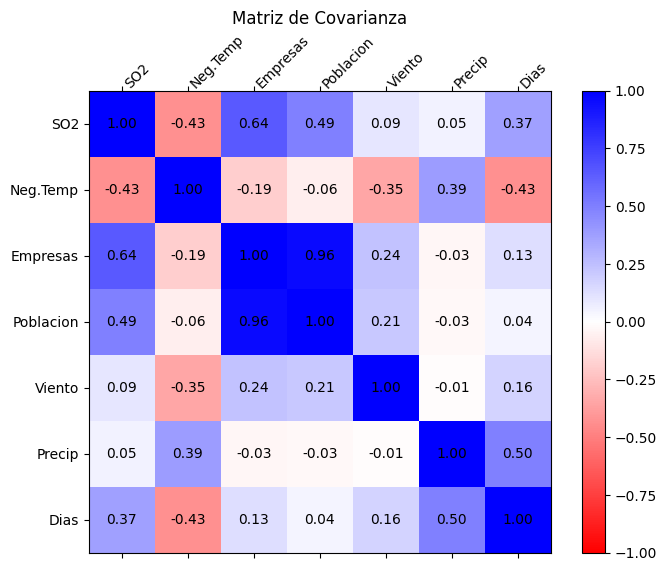

In [90]:
cov_estimator = EmpiricalCovariance()
cov_estimator.fit(df_scaled_numeric)
cov_matrix = cov_estimator.covariance_

plot_covariance_matrix(cov_matrix,variables)


Utilizando el objeto EmpiricalCovariance para calcular la matriz de covarianza, que es parte de la biblioteca scikit-learn, se puede contemplar una estimación más robusta y precisa de la covarianza (los elementos de la diagonal ahora son 1), esto se debe a que en contextos donde los datos pueden tener ciertas propiedades como no ser independientes e idénticamente distribuidos este método es más efectivo.
Además, EmpiricalCovariance realiza ajustes adicionales que pueden contribuir a una estimación más precisa de la varianza y covarianza de los datos.

In [91]:
# Varianza explicada y acumulada
varianza_explicada = pca.explained_variance_ratio_ * 100
varianza_acumulada_explicada = np.cumsum(varianza_explicada)

# Eigenvalues (valores propios)
eigenvalues = pca.explained_variance_

# Creación de DataFrame con la varianza explicada, acumulada y los valores propios
df_varianza = pd.DataFrame({
    'Componente': range(1, len(varianza_explicada) + 1),
    'Valor Propio': eigenvalues,
    'Varianza (%)': varianza_explicada,
    'Varianza acumulada (%)': varianza_acumulada_explicada
})

# Impresión del DataFrame
print(df_varianza.to_string(index=False))

 Componente  Valor Propio  Varianza (%)  Varianza acumulada (%)
          1      2.796323     38.973138               38.973138
          2      1.550143     21.604784               60.577922
          3      1.429847     19.928186               80.506108
          4      0.914291     12.742733               93.248840
          5      0.355448      4.953981               98.202821
          6      0.102795      1.432680               99.635501
          7      0.026153      0.364499              100.000000


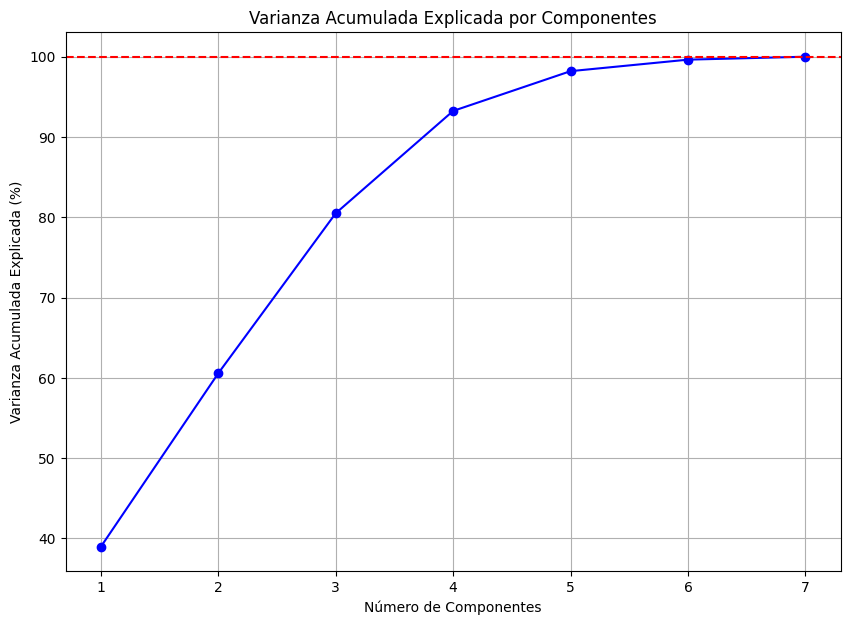

In [92]:

# Visualización de la varianza explicada y acumulada
plt.figure(figsize=(10, 7))
plt.plot(df_varianza['Componente'], df_varianza['Varianza acumulada (%)'], marker='o', linestyle='-', color='blue', label='Varianza acumulada (%)')
plt.title('Varianza Acumulada Explicada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada (%)')
plt.grid(True)
plt.axhline(100, color='red', linestyle='--')

Con dos componentes, se sigue perdiendo aproximadamente el 39.4% de la información que no está representada por esos componentes.

Con tres componentes, se pierde alrededor del 19.4% de la información contenida en los demás componentes.

Seguimos obteniendo los mismos resultados que con el primer método.

In [93]:
styled_df = print_styled_eigenvectors(pca.components_.T, df_scaled_numeric.columns)
display(styled_df)

,Autovector 1,Autovector 2,Autovector 3,Autovector 4,Autovector 5,Autovector 6,Autovector 7
SO2,0.49,-0.08,0.01,-0.40,0.73,0.18,0.15
Neg.Temp,-0.32,0.09,0.68,0.19,0.16,0.61,-0.02
Empresas,0.54,0.23,0.27,0.03,-0.16,-0.04,-0.75
Poblacion,0.49,0.28,0.34,0.11,-0.35,-0.09,0.65
Viento,0.25,-0.06,-0.31,0.86,0.27,0.15,0.02
Precip,0.00,-0.63,0.49,0.18,0.16,-0.55,-0.01
Dias,0.26,-0.68,-0.11,-0.11,-0.44,0.50,0.01


En los autovectores se pueden ver las primeras diferencias entre un método y otro y es que, en el Análisis de Componentes Principales, los autovectores, (componentes principales), tienen una propiedad importante: poseen dirección pero no una orientación fija. Esto quiere decir que la interpretación de los autovectores se centra en la línea que definen en el espacio multidimensional, sin importar en qué sentido apunten a lo largo de la línea.

La implicación matemática de esta propiedad es que si un vector es un autovector de una matriz de covarianza, su opuesto (el vector multiplicado por -1) también lo es. Ambos vectores señalan en la misma línea de reflexión a través del origen, pero en sentidos opuestos.

Esto resulta en las diferencias en los signos de los coeficientes de los autovectores cuando se realiza el análisis de PCA mediante métodos distintos.

Esta diferencia en los signos no tiene efecto sobre la varianza explicada por cada componente principal, que es la cantidad de información de los datos que cada componente captura. Así, mientras que los signos de los autovectores pueden variar, la contribución de cada variable original a cada componente principalpermanece constante.

***Visualización en 3D de los Datos Transformados***

**Componente Principal 1 (CP1)**: La componente principal uno no sufrió variaciones con respecto al anterior método y como destacamos esta componente tiene una fuerte influencia positiva de las variables "empresas" , "Población" y "SO2" , y una influencia negativa de la "Temperatura anual".


**Para la Componente Principal 2 (CP2)**, ahora observamos que la "Precipitación anual media" (Precip) y los "Días lluviosos al año" (Dias) tienen una fuerte influencia negativa, lo cual es un cambio con respecto al apartado anterior donde era positiva. Esto significa que ahora, en el CP2, a medida que aumentan los valores de precipitación y días lluviosos, el valor de la componente tiende a disminuir. Por otro lado, el "Número de empresas mayores de 20 trabajadores" (Empresas) y la "Población" tienen una influencia esta vez positiva.

**Para la Componente Principal 3 (CP3)**, la "Temperatura anual media" (Neg.Temp) ahora tiene una fuerte influencia positiva, lo que representa un cambio en comparación con el anterior método utilizado. Con este cambio, un valor más alto en la "Temperatura anual media" está asociado con valores más altos en CP3, lo que implica que las ciudades con temperaturas más altas se correlacionan con valores más altos en esta componente.

La "Precipitación anual media" (Precip) pasa a tener una influencia positiva.

In [94]:
df_pca = pd.concat([df_pca, df[['Ciudad']]], axis=1)

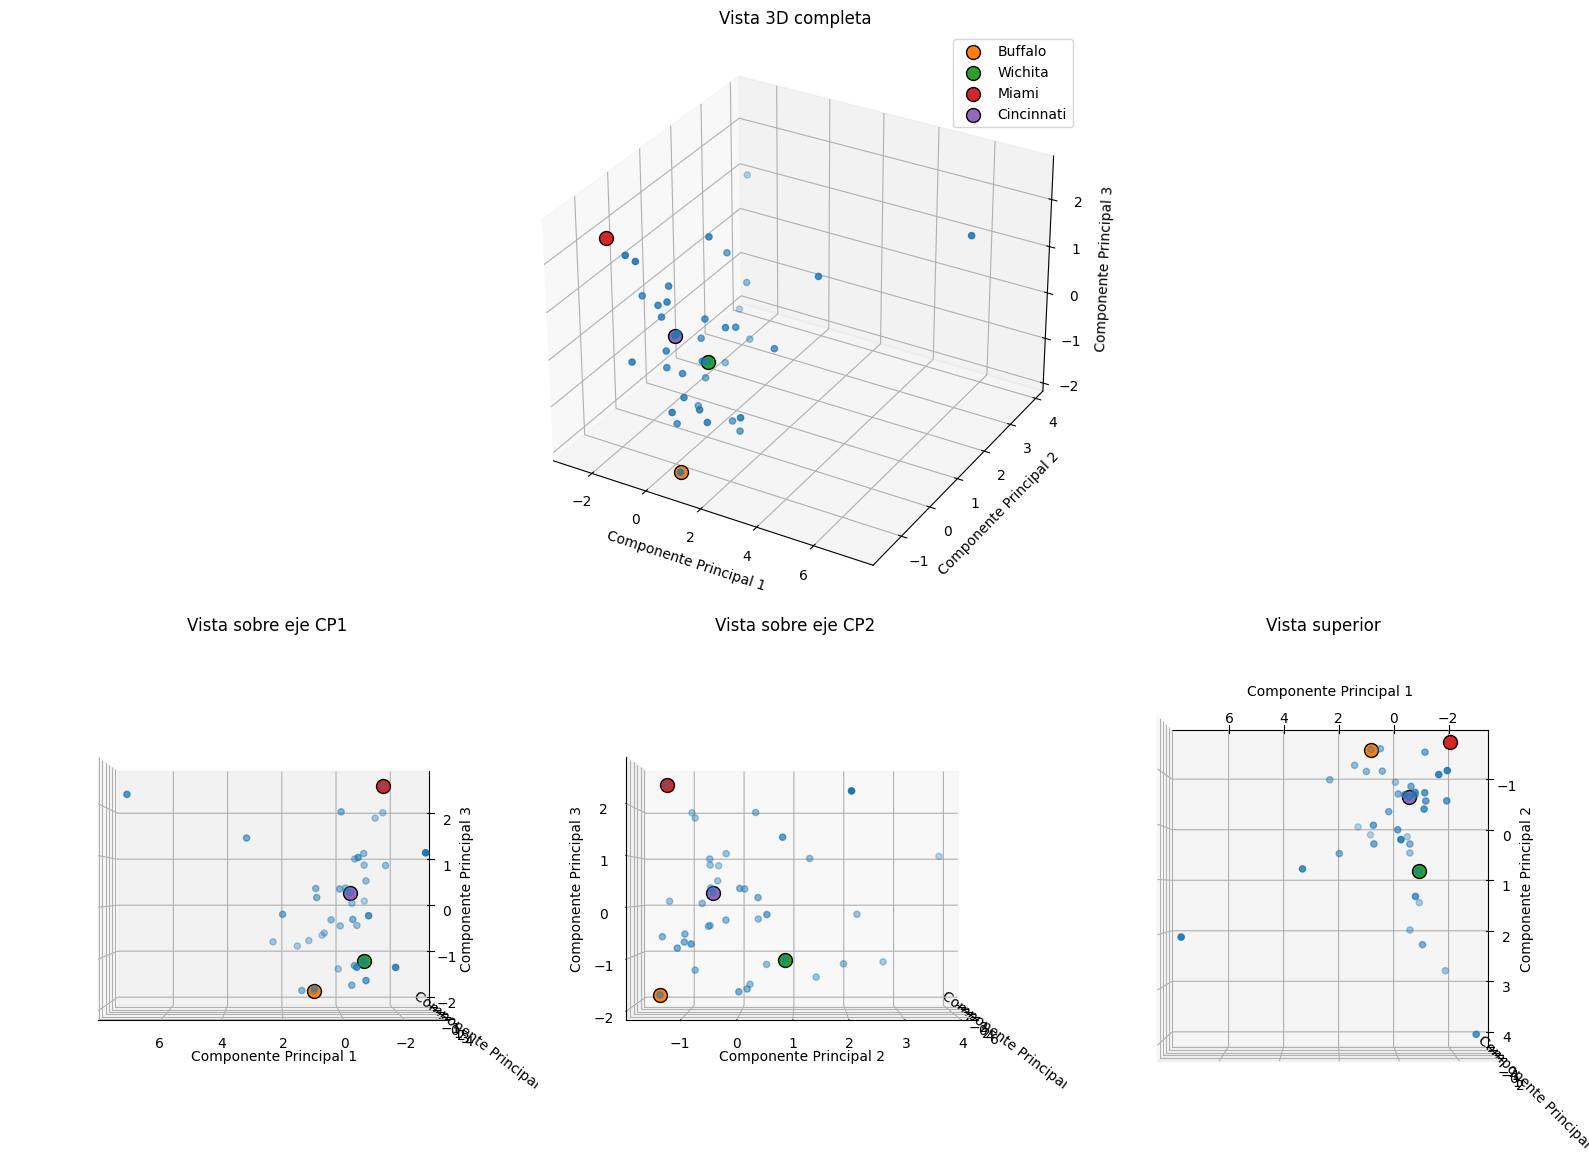

In [95]:
# Configuración de la figura y los ejes
fig = plt.figure(figsize=(16, 12))

# Gráfico completo en la primera fila
ax_full = fig.add_subplot(2, 3, (1, 3), projection='3d')
ax_full.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'])
ax_full.set_xlabel('Componente Principal 1')
ax_full.set_ylabel('Componente Principal 2')
ax_full.set_zlabel('Componente Principal 3')
ax_full.set_title('Vista 3D completa')

# Subplots para vistas detalladas
axs = [fig.add_subplot(2, 3, i+4, projection='3d') for i in range(3)]

# Configuraciones para cada subplot detallado
views = [(0, 90), (0, 0), (90, 90)]
titles = ['Vista sobre eje CP1', 'Vista sobre eje CP2', 'Vista superior']

for ax, view, title in zip(axs, views, titles):
    ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'])
    ax.view_init(elev=view[0], azim=view[1])
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.set_zlabel('Componente Principal 3')
    ax.set_title(title)

# Semilla aleatoria para reproducibilidad
np.random.seed(42)

# Selección de ciudades aleatorias y visualización en todos los gráficos
random_cities = df_pca['Ciudad'].sample(n=4)
for city in random_cities:
    city_data = df_pca[df_pca['Ciudad'] == city]
    for ax in [ax_full] + axs:
        ax.scatter(city_data['PC1'], city_data['PC2'], city_data['PC3'], s=100, edgecolors='k', label=city)

# Leyenda solo en el gráfico completo
ax_full.legend()

# Mostrar la figura
plt.tight_layout()
plt.show()


Esta modificación de signos en CP2 y CP3 no altera la distinción comparativa entre las ciudades. Las que antes se distinguen por valores altos o bajos en una componente, mantienen su posición distintiva, pero la naturaleza de esa distinción se invierte. Las ciudades con altos valores en precipitación y días lluviosos, por ejemplo, ahora se presentan en el extremo negativo de CP2, reflejando la nueva orientación de la componente.